In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm 
from iminuit import Minuit
from iminuit import cost
from iminuit.cost import LeastSquares
import pandas as pd
import sympy as sp
from sympy import symbols, diff, lambdify, solve 
from numpy.linalg import inv
from scipy.integrate import quad
import random

r = np.random

plt.rcParams['figure.figsize'] = [10, 10]


# 1.1 - Done

In [113]:
# It should be 6 days, since 1/6*(1-1/6^100).Of course we can pretty much ignore the parenthesis, as 1/6^100 <<<1 We can test this
days = 10000000
a = r.choice([1,2,3,4,5,6],size = days)
throws = np.sum(a==6)
print(throws/days) # so roughly 1/6


0.166752


In [114]:
days = 300
pushups = []
repeat = True
while repeat:
    for _ in range(days):
        a = r.choice([1,2,3,4,5,6])
        if a == 6:
            dicethrow = r.choice([1,2,3,4,5,6],size = 100)
            pushups.append(np.sum(dicethrow==6))
            repeat = False
print(np.mean(pushups)) # so roughly 1/6*100 = 16.66...
print(np.median(pushups)) # so roughly 1/6*100
print(np.std(pushups))
print(np.std(pushups)/np.sqrt(days)) # standard deviation of binomial: sqrt(n*p(1-p)) = sqrt(100*1/6*5/6) = 3.73

16.27906976744186
17.0
3.9018515664098876
0.22527350522047113


# 1.2 - forhåbelig færdig

#Probability of choosing 1 random angle and getting 3 (When using integer values) is 6/360 = 1/180 ~~0.55%  

In [185]:
#Probability of choosing 1 random angle and getting 3 (When using integer values) is 2/360 = 1/180 ~~0.55%
#However, the probability of choosing a random value between 177 and 3 is just 6/180 which is 4.44%
#Write bayesian statistics in the pdf instead, not gonna do markdown here

# 2.1 - færdig, måske

In [116]:
protomean = 25
protostd =  5
nprotovals = int(1e6)
protovals = r.normal(protomean, protostd, nprotovals)
cometmean = 309
cometstd =  20  
ncometvals = nprotovals
earthmean = 149
earthstd = 3
nearthvals = nprotovals
f = (earthmean-protomean)/(cometmean - protomean)
print("mean is ",f*cometmean + (1-f)*protomean)
print(f)
print("std would be", np.sqrt((f)**2*(cometstd)**2 + (1-f)**2*(protostd)**2))
#Guessing we can't get it down to +-3, as we have an easier time decreasing errors here on earth than in space?


mean is  149.0
0.43661971830985913
std would be 9.175491535156242


# 2.2 - Færdig

In [117]:
dt = 98.4
dterr = 3.7
N = 1971
rate = N/dt
rerr = abs(N/dt**2*dterr)
print("The rate is ",rate, "with an error of ", rerr)
print("The relative uncertainty is", rerr/rate)


The rate is  20.030487804878046 with an error of  0.7531789113622843
The relative uncertainty is 0.037601626016260166


In [118]:
#Hvis den skal være mindre end 2.5% = 0.025 så indsætter vi ligningen for rerr i ligningen for relativ usikkerhed og løser for N
#Hvis vi antager konstant rate har vi 
#N*sigmadt/(dt**2*r) = 0.025, og løs for tiden
#Hvis vi ikke antager konstant rate har vi 
#sigmadt/(dt) = 0.025, t = sigmadt/0.025
print("The number of time needed to measure a relative uncertainty of 2.5% is", dterr/0.025, "assuming a non-constant rate")

The number of time needed to measure a relative uncertainty of 2.5% is 148.0 assuming a non-constant rate


# 2.3 Færdig

<ErrorView mu=3.49476589672609 sigma=0.49714367941677573 N=0.4973878323705909>
0.0 0.1348 0.0226 0.0078


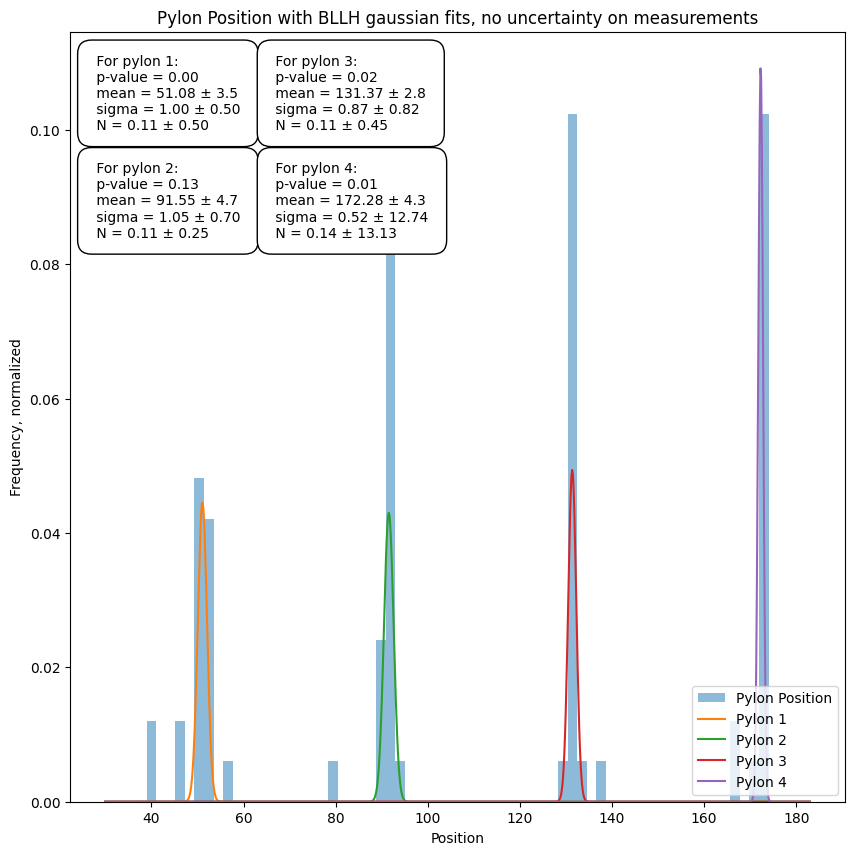

In [119]:
dataframe = pd.read_csv('data_PylonPositions.csv', header=0)
Ppos, Ppos_unc = dataframe.values.T
mask_without_unc = Ppos_unc == -1    
Ppos_without_unc = Ppos[mask_without_unc]
Ppos_with_unc = Ppos[~mask_without_unc]
Ppos_unc = Ppos_unc[~mask_without_unc]
binnumber = 65
density_true = True
def gauss(x, mu, sigma,N):
    return N/np.sqrt(2*np.pi*sigma**2)*np.exp(-0.5*(x-mu)**2/sigma**2)
counts, bins = np.histogram(Ppos_without_unc, bins=binnumber,density=density_true)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]
zeromask = counts > 0
counts = counts[zeromask]
bin_centers = bin_centers[zeromask]
pylon1mask = (bin_centers > 30) & (bin_centers < 70)
pylon2mask = (bin_centers > 70) & (bin_centers < 120)
pylon3mask = (bin_centers > 120) & (bin_centers < 150)
pylon4mask = bin_centers > 140
def binned_log_likelihood1(mu, sigma, N):
    expected = gauss(bin_centers[pylon1mask], mu, sigma, N) * bin_width
    expected = np.clip(expected, 1e-11, None) 
    return -2 * np.sum(counts[pylon1mask] * np.log(expected) - expected)
def binned_log_likelihood2(mu, sigma, N):
    expected = gauss(bin_centers[pylon2mask], mu, sigma, N) * bin_width
    expected = np.clip(expected, 1e-11, None) 
    return -2 * np.sum(counts[pylon2mask] * np.log(expected) - expected)
def binned_log_likelihood3(mu, sigma, N):
    expected = gauss(bin_centers[pylon3mask], mu, sigma, N) * bin_width
    expected = np.clip(expected, 1e-8, None) 
    return -2 * np.sum(counts[pylon3mask] * np.log(expected) - expected)
def binned_log_likelihood4(mu, sigma, N):
    expected = gauss(bin_centers[pylon4mask], mu, sigma, N) * bin_width
    expected = np.clip(expected, 1e-11, None) 
    return -2 * np.sum(counts[pylon4mask] * np.log(expected) - expected)
def P_val_BLLH(param1,cov1,param2,cov2,param3,cov3,param4,cov4,sample_size = 5000):
    final_chi1 = m1.fval
    final_chi2 = m2.fval
    final_chi3 = m3.fval
    final_chi4 = m4.fval
    chi1_random = []
    chi2_random = []
    chi3_random = []
    chi4_random = []
    for i in range(sample_size):
        data1 = np.random.multivariate_normal(param1,cov1)
        data2 = np.random.multivariate_normal(param2,cov2)
        data3 = np.random.multivariate_normal(param3,cov3)
        data4 = np.random.multivariate_normal(param4,cov4)
        chi1_random.append(binned_log_likelihood1(*data1))
        chi2_random.append(binned_log_likelihood2(*data2))
        chi3_random.append(binned_log_likelihood3(*data3))
        chi4_random.append(binned_log_likelihood4(*data4))
    p_val1 = np.mean(np.array(chi1_random) <= final_chi1)
    p_val2 = np.mean(np.array(chi2_random) <= final_chi2)
    p_val3 = np.mean(np.array(chi3_random) <= final_chi3)
    p_val4 = np.mean(np.array(chi4_random) <= final_chi4)
    return p_val1,p_val2,p_val3,p_val4

binspace = np.linspace(min(bin_centers) - 10, max(bin_centers) + 10, 1000)
binwidth = bin_centers[1] - bin_centers[0]
plt.hist(Ppos_without_unc, bins=binnumber, density=density_true,alpha=0.5, label='Pylon Position')
m1 = Minuit(binned_log_likelihood1, mu=50, sigma=0.1, N=1)
m1.limits["mu"] = (48, 52)
m1.limits["sigma"] = (0.5,1)
m1.limits["N"] = (0.02,1) 
m1.migrad()

m2 = Minuit(binned_log_likelihood2, mu=96, sigma=0.1, N=0.2)
m2.limits["mu"] = (87,92 )
m2.limits["sigma"] = (0.5,1.5)
m2.limits["N"] = (0.02,0.5)  
m2.migrad()

m3 = Minuit(binned_log_likelihood3, mu=133, sigma=0.4, N=0.2)
m3.limits["mu"] = (130,140 )
m3.limits["sigma"] = (0.5,2)
m3.limits["N"] = (0.02,0.9)  
m3.migrad()

m4 = Minuit(binned_log_likelihood4, mu=172, sigma=.5, N=0.1)
m4.limits["mu"] = (169,175 )
m4.limits["sigma"] = (0.04,None)
m4.limits["N"] = (0,None)  
m4.migrad()

# Extract fit results  
mu1 = m1.values['mu']
sigma1 = m1.values['sigma']
N1 = m1.values['N']
mu2 = m2.values['mu']
sigma2 = m2.values['sigma']
N2 = m2.values['N']
mu3 = m3.values['mu']
sigma3 = m3.values['sigma']
N3 = m3.values['N']
mu4 = m4.values['mu']
sigma4 = m4.values['sigma']
N4 = m4.values['N']

plt.plot(binspace, gauss(binspace, mu1, sigma1, N1), label=f'Pylon 1')# {mu1:.2f} ± {m1.errors["mu"]:.2f}')
plt.plot(binspace, gauss(binspace, mu2, sigma2, N2), label=f'Pylon 2')# {mu2:.2f} ± {m2.errors["mu"]:.2f}')
plt.plot(binspace, gauss(binspace, mu3, sigma3, N3), label=f'Pylon 3')# {mu3:.2f} ± {m3.errors["mu"]:.2f}')
plt.plot(binspace, gauss(binspace, mu4, sigma4, N4), label=f'Pylon 4')# {mu4:.2f} ± {m4.errors["mu"]:.2f}')
print(m1.errors)
param1 = [mu1,sigma1,N1]
cov1 = np.copy(np.array(m1.covariance))
param2 = [mu2,sigma2,N2]
cov2 = np.copy(np.array(m2.covariance))
param3 = [mu3,sigma3,N3]
cov3 = np.copy(np.array(m3.covariance))
param4 = [mu4,sigma4,N4]

cov4 = np.copy(np.array(m4.covariance))
pval1,pval2,pval3,pval4 = P_val_BLLH(param1,cov1,param2,cov2,param3,cov3,param4,cov4) # simulating data for them nice n juicy p vals
text_box_1 = f" For pylon 1:\n p-value = {pval1:.2f} \n mean = {mu1:.2f} ± {m1.errors['mu']:.1f} \n sigma = {sigma1:.2f} ± {m1.errors['sigma']:.2f} \n N = {N1:.2f} ± {m1.errors['N']:.2f}"
text_box_2 = f" For pylon 2:\n p-value = {pval2:.2f} \n mean = {mu2:.2f} ± {m2.errors['mu']:.1f} \n sigma = {sigma2:.2f} ± {m2.errors['sigma']:.2f} \n N = {N2:.2f} ± {m2.errors['N']:.2f}"
text_box_3 = f" For pylon 3:\n p-value = {pval3:.2f} \n mean = {mu3:.2f} ± {m3.errors['mu']:.1f} \n sigma = {sigma3:.2f} ± {m3.errors['sigma']:.2f} \n N = {N3:.2f} ± {m3.errors['N']:.2f}"
text_box_4 = f" For pylon 4:\n p-value = {pval4:.2f} \n mean = {mu4:.2f} ± {m4.errors['mu']:.1f} \n sigma = {sigma4:.2f} ± {m4.errors['sigma']:.2f} \n N = {N4:.2f} ± {m4.errors['N']:.2f}"
print(pval1,pval2,pval3,pval4)
plt.text(27, 0.1, text_box_1, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.text(27, 0.084, text_box_2, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.text(66, 0.1, text_box_3, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.text(66, 0.084, text_box_4, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.legend(loc = 'lower right')
plt.xlabel('Position')
plt.ylabel('Frequency, normalized')
plt.title('Pylon Position with BLLH gaussian fits, no uncertainty on measurements')
plt.show()

In [120]:
#I'm gonna be honest, i could tr and do the same BLLH fit but since theres only ~10 values for each pylon its not gonna be possible to get a good fit.
pylon1 = Ppos_with_unc[Ppos_with_unc < 70]
pylon2 = Ppos_with_unc[(Ppos_with_unc > 70) & (Ppos_with_unc < 120)]
pylon3 = Ppos_with_unc[(Ppos_with_unc > 120) & (Ppos_with_unc < 150)]
pylon4 = Ppos_with_unc[Ppos_with_unc > 140]
pylon1unc = Ppos_unc[Ppos_with_unc < 70]
pylon2unc = Ppos_unc[(Ppos_with_unc > 70) & (Ppos_with_unc < 120)]
pylon3unc = Ppos_unc[(Ppos_with_unc > 120) & (Ppos_with_unc < 150)]
pylon4unc = Ppos_unc[Ppos_with_unc > 140]

weightedaverage_pylon1 = np.average(pylon1,weights = 1/pylon1unc**2)
std1 = np.sqrt(1 / np.sum(1/pylon1unc**2))
weightedaverage_pylon2 = np.average(pylon2,weights = 1/pylon2unc**2)
std2 = np.sqrt(1 / np.sum(1/pylon2unc**2))
weightedaverage_pylon3 = np.average(pylon3,weights = 1/pylon3unc**2)
std3 = np.sqrt(1 / np.sum(1/pylon3unc**2))
weightedaverage_pylon4 = np.average(pylon4,weights = 1/pylon4unc**2)
std4 = np.sqrt(1 / np.sum(1/pylon4unc**2))
print(f"The weighted average for pylon 1 is {weightedaverage_pylon1:.3f} with a standard deviation of {std1:.3f}")
print(f"The weighted average for pylon 2 is {weightedaverage_pylon2:.3f} with a standard deviation of {std2:.3f}")
print(f"The weighted average for pylon 3 is {weightedaverage_pylon3:.3f} with a standard deviation of {std3:.3f}")
print(f"The weighted average for pylon 4 is {weightedaverage_pylon4:.3f} with a standard deviation of {std4:.3f}")


The weighted average for pylon 1 is 50.574 with a standard deviation of 0.616
The weighted average for pylon 2 is 93.181 with a standard deviation of 0.250
The weighted average for pylon 3 is 132.381 with a standard deviation of 0.236
The weighted average for pylon 4 is 171.439 with a standard deviation of 0.246


[ 51.06289127  91.55088212 131.37464678 172.27531165]
[0.60665298 0.24925865 0.23561561 0.24572902]


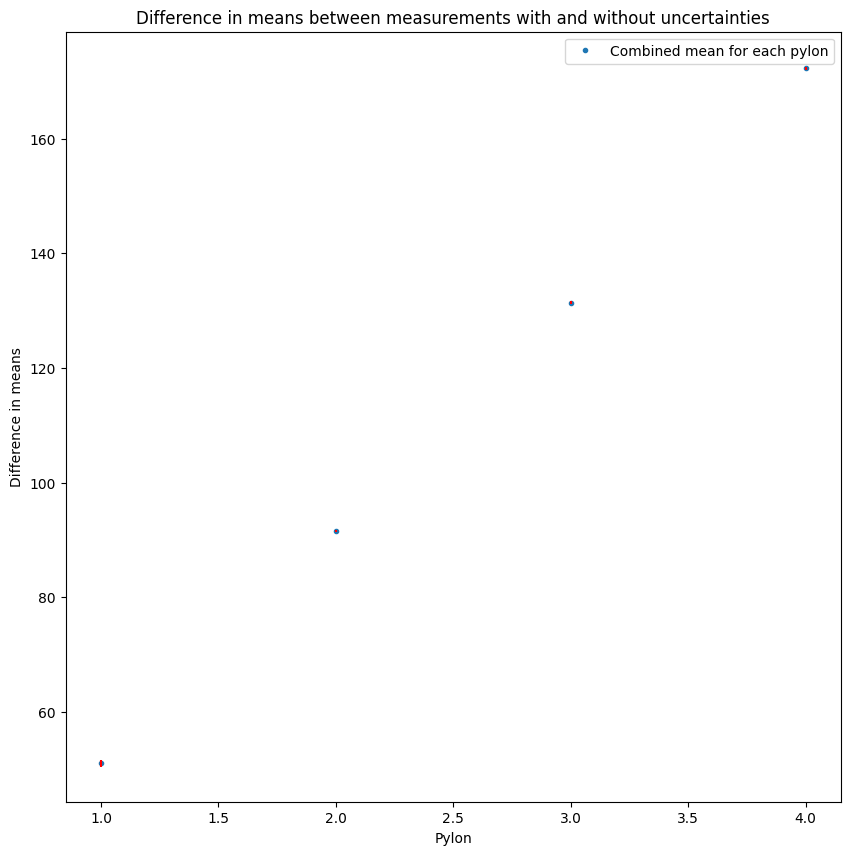

In [121]:
mu_no_unc = np.array([mu1, mu2, mu3, mu4])
mu_no_uncerr = np.array([m1.errors['mu'], m2.errors['mu'], m3.errors['mu'], m4.errors['mu']])
mu_with_unc = np.array([weightedaverage_pylon1, weightedaverage_pylon2, weightedaverage_pylon3, weightedaverage_pylon4])
mu_with_uncerr = np.array([std1, std2, std3, std4])
new_mu = []
new_mu_err = []
for i in range(4):
    new_mu.append((mu_no_unc[i]/mu_with_uncerr[i]**2 + mu_with_unc[i]/mu_no_uncerr[i]**2)/(1/mu_no_uncerr[i]**2 + 1/mu_with_uncerr[i]**2))
    new_mu_err.append(1/np.sqrt(1/mu_no_uncerr[i]**2 + 1/mu_with_uncerr[i]**2))
new_mu = np.array(new_mu)
new_mu_err = np.array(new_mu_err)
plt.plot([1,2,3,4], new_mu, '.', label='Combined mean for each pylon')
plt.errorbar([1,2,3,4], new_mu, yerr=new_mu_err,color = "red", fmt='none')
plt.xlabel('Pylon')
plt.ylabel('Difference in means')
plt.title('Difference in means between measurements with and without uncertainties')
plt.legend()
#plt.show()
print(new_mu)
print(new_mu_err)

The slope is  40.38079221062489 with an error of  0.2267275082615009


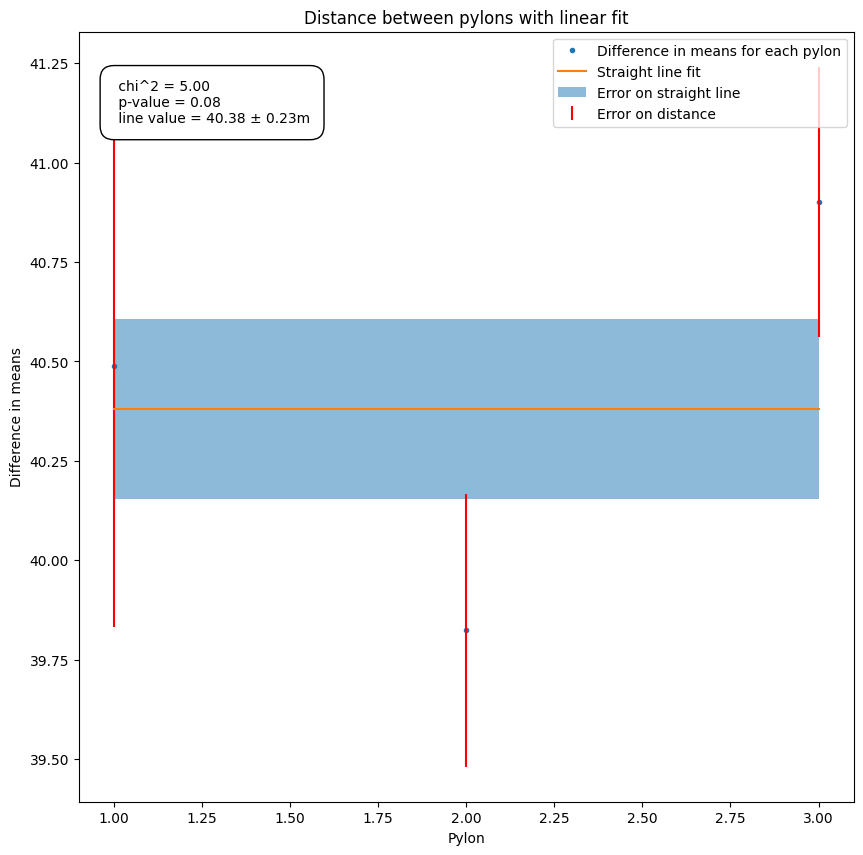

As such all pylons are within the error of being equidistant


In [122]:
#We can check if they're equidistant by using the np.diff
dpylon = np.diff(new_mu)
dpylonerr = np.sqrt(new_mu_err[1:]**2 + new_mu_err[:-1]**2)

def linfunc(x,a):
    return a +x-x
chilinfit = LeastSquares([1,2,3],dpylon, dpylonerr,linfunc)
m = Minuit(chilinfit, a=1)
m.migrad()
pval = stats.chi2.sf(m.fval, 2)
plt.plot([1,2,3], dpylon, '.', label='Difference in means for each pylon')
plt.errorbar([1,2,3], dpylon, yerr=dpylonerr,color = "red", fmt='none', label = "Error on distance")
plt.plot([1,2,3], linfunc(np.array([1,2,3]),*m.values), label=f'Straight line fit')
print("The slope is ",m.values["a"], "with an error of ", m.errors["a"])
plt.fill_between([1,2,3], linfunc(np.array([1,2,3]),m.values["a"] - m.errors["a"]), linfunc(np.array([1,2,3]),m.values["a"] + m.errors["a"]), alpha = 0.5, label = "Error on straight line")
plt.title('Distance between pylons with linear fit')
plt.legend()
plt.xlabel('Pylon')
plt.ylabel('Difference in means')
text_box_1 = f" chi^2 = {m.fval:.2f}\n p-value = {pval:.2f} \n line value = {m.values['a']:.2f} ± {m.errors['a']:.2f}m"
plt.text(1, 41.1, text_box_1, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.show()
print("As such all pylons are within the error of being equidistant")

In [123]:
#Since we know that they are equidistant, we can again use a weighted mean to find the mean distanec between the pylons
weightedaverage_pylon = np.average(dpylon,weights = 1/dpylonerr**2)
std = np.sqrt(1 / np.sum(1/dpylonerr**2))
print(f"The weighted average for the distance between pylons is {weightedaverage_pylon:.3f} with a standard deviation of {std:.3f}")
print(f"The real distance, 40.83m is {(40.83-1.05-weightedaverage_pylon)/std:.3f} standard deviations away from the weighted average, so we can accept it") #okay wrong, right in pdf..

The weighted average for the distance between pylons is 40.381 with a standard deviation of 0.227
The real distance, 40.83m is -2.650 standard deviations away from the weighted average, so we can accept it


# 3.1 - Færdig

0.20526235198040016 0.0902901728798001


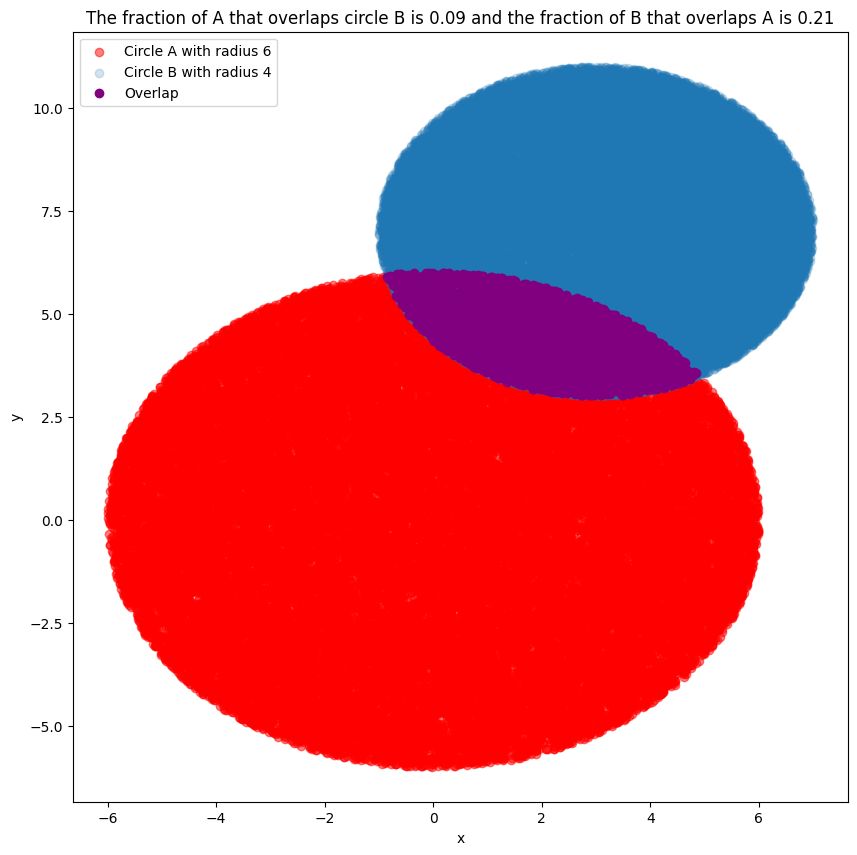

In [124]:
R0 = 6
R1 = 4
x0,y0 = 0,0
x1,y1 = 3,7
def incircle2d(N,R,x,y):
    ranx = np.random.uniform(-R,R,N)
    rany = np.random.uniform(-R,R,N)
    mask = (ranx)**2 + (rany)**2 < R**2
    return ranx[mask]+x, rany[mask]+y
N = 50000
xr0,yr0 = incircle2d(N,R0,x0,y0)
plt.scatter(xr0,yr0,color = 'red', alpha=0.5, label='Circle A with radius 6')
xr1,yr1 = incircle2d(N,R1,x1,y1)
overlapr1r0 = np.sum(((xr1)**2+(yr1)**2 < R0**2))# & (xr0**2+yr0**2 < R1**2)
overlapr0r1 = np.sum(((xr0-x1)**2+(yr0-y1)**2 < R1**2))# & (xr1**2+yr1**2 < R0**2)
print(overlapr1r0/len(xr1), overlapr0r1/len(xr0))

plt.scatter(xr1,yr1, alpha=0.2, label='Circle B with radius 4')
overlap_A_in_B = ((xr0-x1)**2 + (yr0-y1)**2 < R1**2)  # Circle A inside Circle B
overlap_B_in_A = (xr1**2 + yr1**2 < R0**2)  # Circle B inside Circle A
# Plot the overlap region
plt.scatter(xr0[overlap_A_in_B], yr0[overlap_A_in_B], color='purple', alpha=1, label='Overlap')
plt.legend()
plt.title(f"The fraction of A that overlaps circle B is {overlapr0r1/len(xr1):.2f} and the fraction of B that overlaps A is {overlapr1r0/len(xr0):.2f}")
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [125]:
R0 = 6
R1 = 4
x0,y0,z0,w0 = 0,0,0,0
x1,y1,z1,w1 = 3,7,-1,2
def incircle4d(N,R,x,y,z,w):
    ranx = np.random.uniform(-R,R,N)
    rany = np.random.uniform(-R,R,N)
    ranz = np.random.uniform(-R,R,N)
    ranw = np.random.uniform(-R,R,N)
    mask = ranx**2 + rany**2 + ranz**2 +ranw**2< R**2
    return ranx[mask]+x, rany[mask]+y,ranz[mask]+z,ranw[mask]+w
N = 5000000
xr0,yr0,zr0,wr0 = incircle4d(N,R0,x0,y0,z0,w0)
xr1,yr1,zr1,wr1 = incircle4d(N,R1,x1,y1,z1,w1)
overlapr1r0 = np.sum((xr1**2+yr1**2 +zr1**2+wr1**2 < R0**2))# Circle B inside Circle A
overlapr0r1 = np.sum(((xr0-x1)**2+(yr0-y1)**2 + (zr0-z1)**2 + (wr0-w1)**2 < R1**2))# Circle A inside Circle B
print(f"The fractional overlap of B inside circle A is {overlapr1r0/len(xr1):.3f} and the fractional overlap of A inside circle B is {overlapr0r1/len(xr0):.3f}")


The fractional overlap of B inside circle A is 0.074 and the fractional overlap of A inside circle B is 0.015


# 3.2 - Færdig

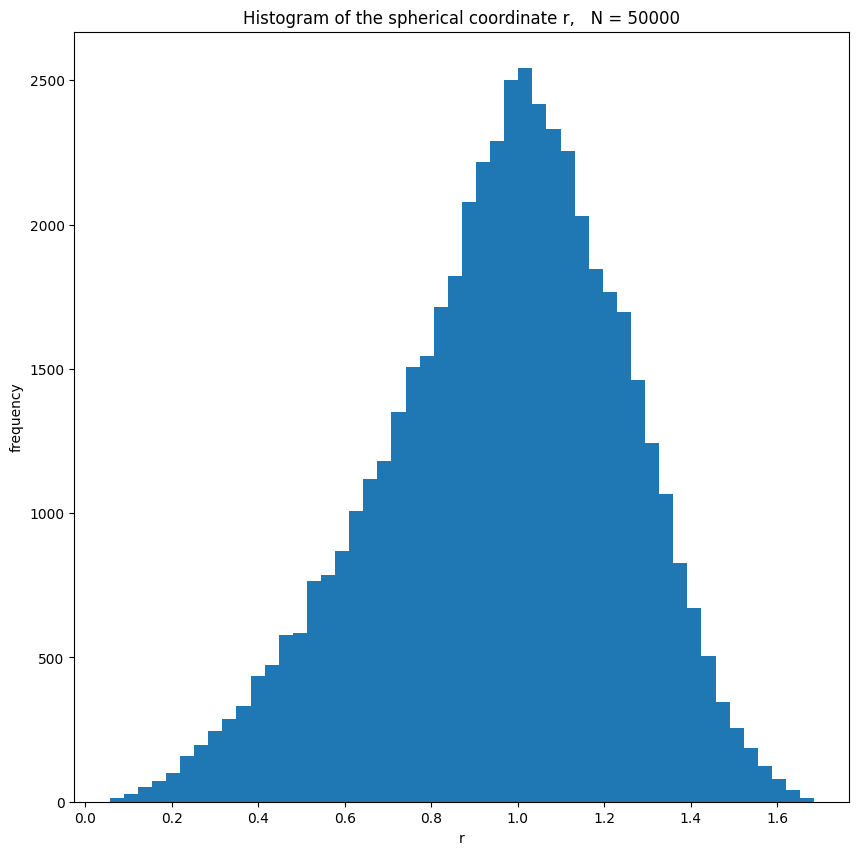

In [126]:
N = 50000
xnum = r.uniform(-1,1,N)
ynum = r.uniform(-1,1,N)
znum = r.uniform(-1,1,N)
R = np.sqrt(xnum**2 + ynum**2 + znum**2)
plt.hist(R,bins = 50)
plt.title("Histogram of the spherical coordinate r,   N = 50000")
plt.xlabel("r")
plt.ylabel("frequency")
plt.show()


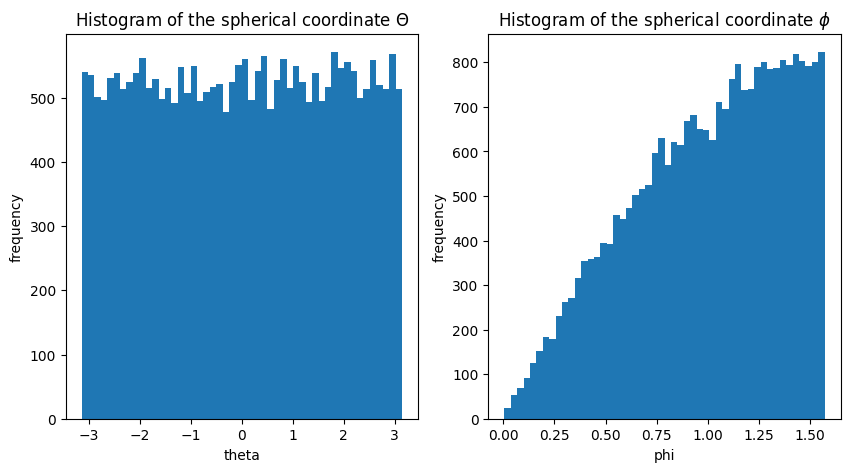

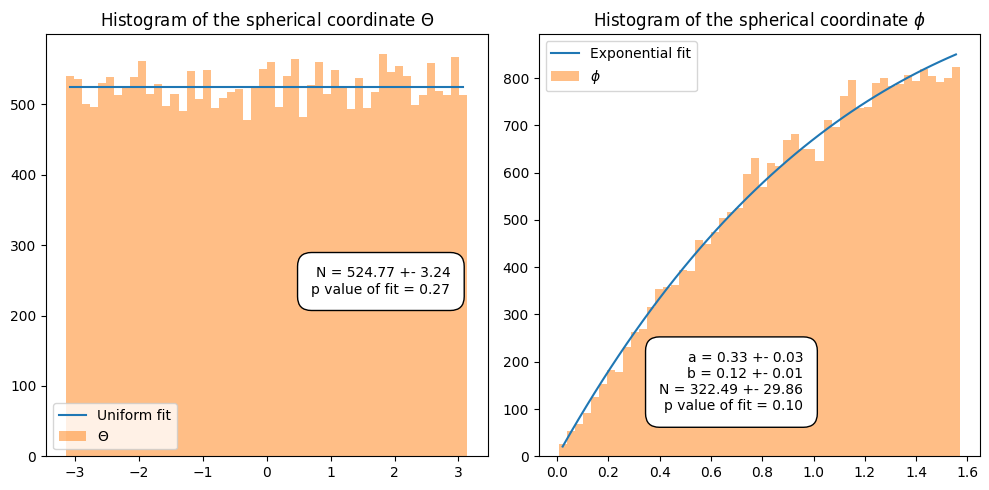

In [202]:
N = 50000
r.seed(43)
Rlist = []
xlist = []
ylist = []
zlist = []
for i in range(N):
    xnum = r.uniform(-1,1,1)
    ynum = r.uniform(-1,1,1)
    znum = r.uniform(0,1,1)
    R = np.sqrt(xnum**2 + ynum**2 + znum**2)
    if R < 1:
        Rlist.append(R)
        xlist.append(xnum)
        ylist.append(ynum)
        zlist.append(znum)
    else:
        continue
Rlist = np.array(Rlist)
xlist = np.array(xlist)
ylist = np.array(ylist)
zlist = np.array(zlist)
phi = np.arccos(zlist/Rlist)
theta = np.arctan2(ylist,xlist)
fig,ax = plt.subplots(1,2,figsize = (10,5))
ax[0].hist(theta,bins = 50)
ax[0].set_title("Histogram of the spherical coordinate $\Theta$")
ax[0].set_xlabel("theta")
ax[0].set_ylabel("frequency")
ax[1].hist(phi,bins = 50)
ax[1].set_title("Histogram of the spherical coordinate $\phi$")
ax[1].set_xlabel("phi")
ax[1].set_ylabel("frequency")
plt.show()
def uniformfit(x,N):
    return x-x+N
def xpol(x,a,b,N):
    return N*x/a*np.exp(-b*(x/a))
fig,ax = plt.subplots(1,2,figsize = (10,5))

countsphi, binsphi = np.histogram(phi, bins=50)
binsphi = (binsphi[1:] + binsphi[:-1])/2
zeromask = countsphi > 0
countsphi = countsphi[zeromask]
binsphi = binsphi[zeromask]

countstheta, binstheta = np.histogram(theta, bins=50)
zeromask2 = countstheta > 0
countstheta = countstheta[zeromask2]
binstheta = (binstheta[1:] + binstheta[:-1])/2
binstheta = binstheta[zeromask2]
binwidth = binstheta[1]-binstheta[0]

chitheta = LeastSquares(binstheta, countstheta, np.sqrt(countstheta), uniformfit)
mtheta = Minuit(chitheta,N = 0.2)
mtheta.migrad()

chiphi = LeastSquares((binsphi), countsphi, np.sqrt(countsphi), xpol)
mphi = Minuit(chiphi,a = 0.5, b = 0.5,N = 100)
mphi.limits['N'] = (0, 100000)
mphi.migrad()

pvalphi = stats.chi2.sf(mphi.fval, len(binsphi)-3)
pvaltheta = stats.chi2.sf(mtheta.fval, len(binstheta)-1)
# ax[0].plot(binstheta, uniformfit((binstheta), *mtheta.values), label=f'Uniform fit ')#with mu = {mtheta.values["mu"]:.2f} +- {mtheta.errors["mu"]:.2f} and sigma = {mtheta.values["sigma"]:.2f} +- {mtheta.errors["sigma"]:.2f}')
# ax[0].hist(theta, bins=50, alpha=0.5,label='$\Theta$')
# ax[0].legend()
# ax[0].set_title(f"Histogram of the spherical coordinate $\Theta$")
# ax[0].text(0.5, 200, f"p = {pvaltheta:.2f}")
# print(pvaltheta)
# ax[1].plot(binsphi, xpol(binsphi, *mphi.values), label=f'Exponential fit ')
# ax[1].hist(phi, bins=50, alpha=0.5,label='$\phi$')
# ax[1].legend()
# ax[1].set_title("Histogram of the spherical coordinate $\phi$")
# ax[1].text(0.5, 200, f"p = {pvalphi:.2f}")
# plt.show()
ax[0].plot(binstheta, uniformfit(binstheta, *mtheta.values), label=f'Uniform fit')
ax[0].hist(theta, bins=50, alpha=0.5, label='$\Theta$')
ax[0].legend()
ax[0].set_title(f"Histogram of the spherical coordinate $\Theta$")
textstr = '\n'.join((
    f'N = {mtheta.values["N"]:.2f} +- {mtheta.errors["N"]:.2f}',
    f'p value of fit = {pvaltheta:.2f}'
))
ax[0].text(-0.2, 0.45, textstr, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', horizontalalignment='right', 
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

#fig.text(0.75, 0.60, f"p value of fit = {pvaltheta:.2f}", ha='center', va='center', fontsize=12, color='black')
textstr2 = '\n'.join((
    f'a = {mphi.values["a"]:.2f} +- {mphi.errors["a"]:.2f}',
    f'b = {mphi.values["b"]:.2f} +- {mphi.errors["b"]:.2f}',
    f'N = {mphi.values["N"]:.2f} +- {mphi.errors["N"]:.2f}',
    f'p value of fit = {pvalphi:.2f}'
))
ax[1].text(0.6, 0.25, textstr2, transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', 
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
ax[1].plot(binsphi, xpol(binsphi, *mphi.values), label=f'Exponential fit')
ax[1].hist(phi, bins=50, alpha=0.5, label='$\phi$')
ax[1].legend()
ax[1].set_title("Histogram of the spherical coordinate $\phi$")

#fig.text(0.25, 0.60, f"p value of fit = {pvalphi:.2f}", ha='center', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()


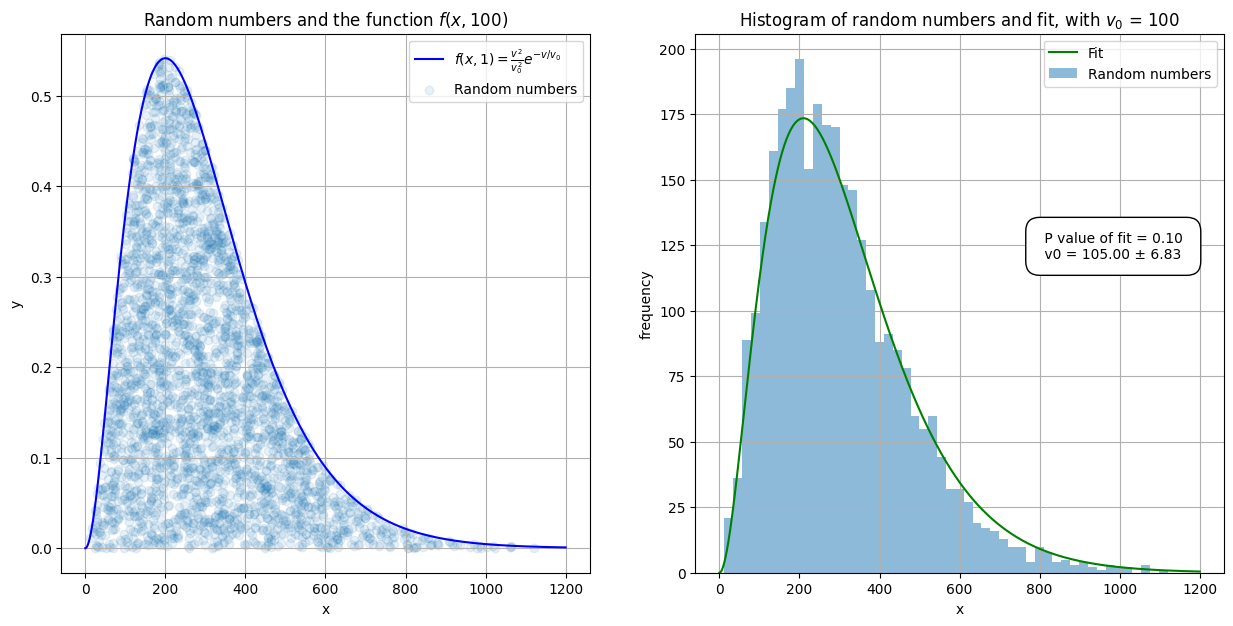

In [128]:
# Vi kan ikke isolere for x, så  transformation kan ikke bruges. Hit and miss kan bruges, siden den går mod nul meget hurtigt, og dermed kan vi definere et interval hvor vi kan lave hit and miss
def f(x,v0,N = 1):
    return N*(x/v0)**2*np.exp(-x/v0)
N = 10000
xran = r.uniform(0,1200,N)
yran = r.uniform(0,max(f(xran,v0 = 100)),N)
mask = yran < f(xran,100)
yran = yran[mask]
p = np.argsort(yran)
yran = yran[p]
xran = xran[mask][p]
counts,bins = np.histogram(xran, bins=50)
bins = (bins[1:] + bins[:-1])/2
counts0mask = counts > 0
counts = counts[counts0mask]
bins = bins[counts0mask]
binspace = np.linspace(0, 1200, 5000)
x_vals = np.copy(binspace)
y_vals = f(x_vals, 100)

chi2fit = LeastSquares(bins, counts, np.sqrt(counts), f)
m2 = Minuit(chi2fit, v0 = 100,N= 1)
m2.limits['v0'] = (97, 105)
m2.migrad()
pvalfit2 = stats.chi2.sf(m2.fval, len(bins)-2)
text_box_4 = f" P value of fit = {pvalfit2:.2f} \n v0 = {m2.values['v0']:.2f} ± {m2.errors['v0']:.2f}"
fig,ax = plt.subplots(1,2, figsize = (15,7))
ax[1].plot(binspace,f(binspace,*m2.values), label='Fit', color='green')
ax[1].hist(xran, bins=50, alpha=0.5, label='Random numbers')
ax[1].legend()
ax[1].grid()
ax[1].set_title(f'Histogram of random numbers and fit, with $v_0$ = 100')
ax[1].set_xlabel('x')
ax[1].set_ylabel('frequency')
ax[1].text(800, 120, text_box_4, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

ax[0].plot(x_vals, y_vals, label=r'$f(x, 1) = \frac{v^2}{v_0^2} e^{-v/v_0}$', color='blue')
ax[0].scatter(xran, yran, alpha=0.1, label='Random numbers')
ax[0].set_title('Random numbers and the function $f(x, 100)$')
ax[0].legend()
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid()
plt.show()



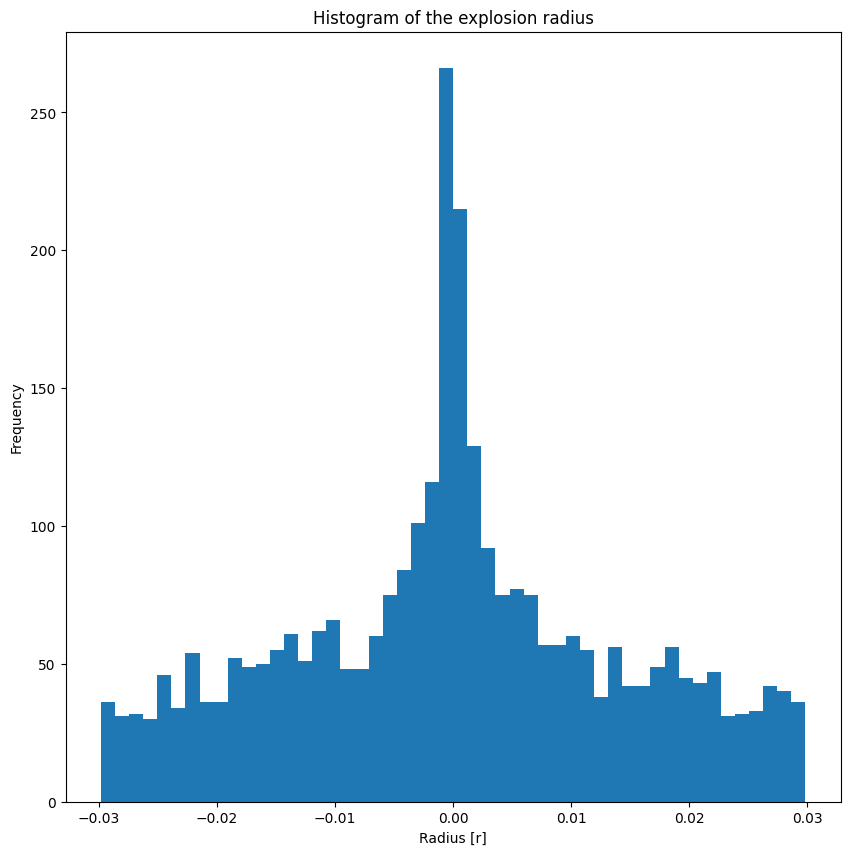

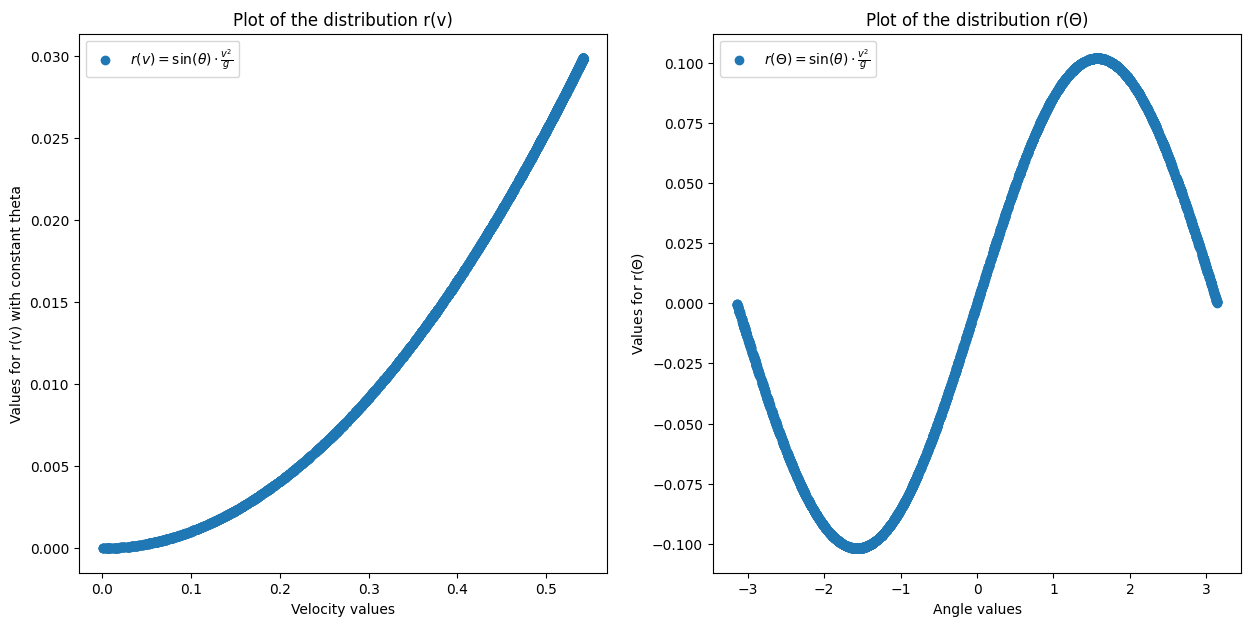

In [204]:
def explosionr(v,theta,g = 9.82):
    return v**2*np.sin(theta)/g

#Vi laver hit and miss på funktionen f(x) =N*x/a*np.exp(-b*(x/a)), siden vi kan lave samme trick som med denne anden funktion
N = 10000
v0 = 100
xran = r.uniform(0,1200,N)
yran = r.uniform(0,max(f(xran,v0 = v0)),N)
mask = yran < f(xran,v0)
yran = yran[mask]
xran = xran[mask]
vvals = f(xran,v0)
thetavals = r.uniform(-np.pi,np.pi,len(vvals))
rvals = explosionr(vvals,thetavals)
plt.hist(rvals,bins = 50)
plt.title("Histogram of the explosion radius")
plt.xlabel("Radius [r]")
plt.ylabel("Frequency")
plt.show()
# plt.figure(figsize=(6, 6))
# ax = plt.subplot(111, projection='polar')
# ax.scatter(thetavals, rvals, label=r"$r(\Theta) = \sin(\theta) \cdot \frac{v^2}{g}$")
# ax.set_title("Polar Plot of the Distribution")
# ax.set_xlabel("Angle $\Theta$")
# ax.set_ylabel("Distribution $r(\Theta)$")
# plt.legend()
# plt.show()
rconstant = explosionr(vvals,np.pi/2)
fig,ax = plt.subplots(1,2, figsize = (15,7))
ax[0].scatter(vvals,rconstant, label=r"$r(v) = \sin(\theta) \cdot \frac{v^2}{g}$")
ax[0].set_title("Plot of the distribution r(v)")
ax[0].set_xlabel('Velocity values')
ax[0].set_ylabel("Values for r(v) with constant theta")
ax[0].legend()
rvconstant = explosionr(1,thetavals)
ax[1].scatter(thetavals,rvconstant, label=r"$r(\Theta) = \sin(\theta) \cdot \frac{v^2}{g}$")
ax[1].set_title("Plot of the distribution r($\Theta$)")
ax[1].set_xlabel('Angle values')
ax[1].set_ylabel("Values for r($\Theta$)")
ax[1].legend()
plt.show()



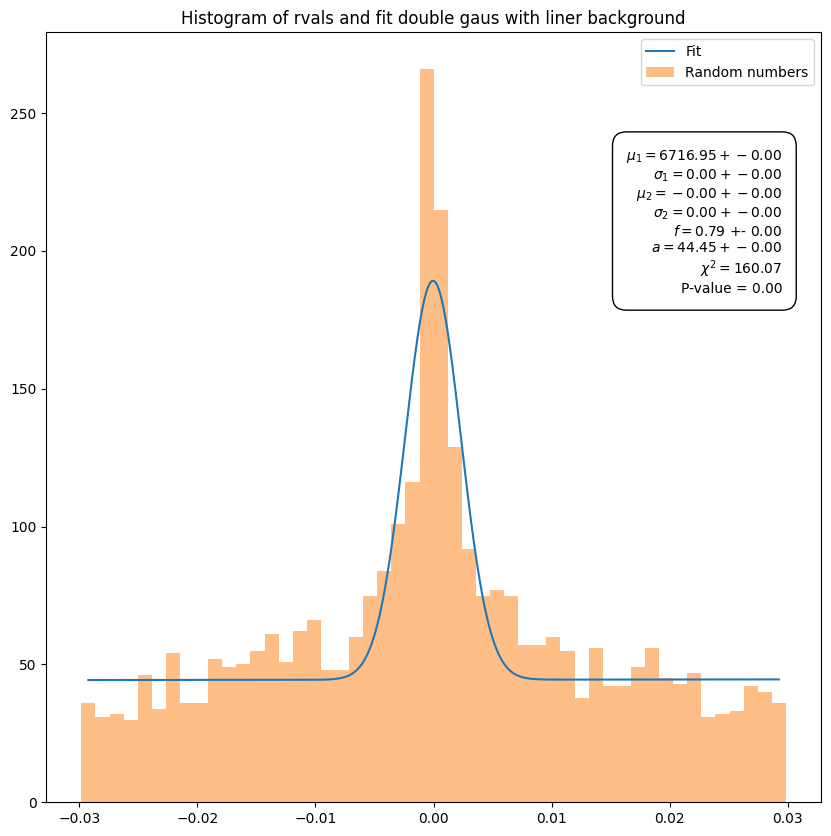

In [206]:
def lintwogaus(x, mu1, sigma1, N, mu2,sigma2, f,a):
    return N*(f*norm.pdf(x, mu1, sigma1) + (1-f)*norm.pdf(x, mu2, sigma2)+x)+a

counts,bins = np.histogram(rvals, bins=50,density = False)
bins = (bins[1:] + bins[:-1])/2
zeromask = counts > 0
counts = counts[zeromask]
bins = bins[zeromask]
binwidth = bins[1]-bins[0]
chilingaus = LeastSquares(bins, counts, np.sqrt(counts), lintwogaus)
mgaus = Minuit(chilingaus, mu1 = 0.01, sigma1 = 0.01, N = binwidth*counts.sum(), mu2 = 0,sigma2 = 0.01, f = 0.2, a = 50,)
mgaus.limits['mu1'] = (0,None)
mgaus.limits['sigma1'] = (0,None)
mgaus.limits['sigma2'] = (0,None)
mgaus.limits['f'] = (0,1)
mgaus.limits['a'] = (0,None)
mgaus.migrad()
pval = stats.chi2.sf(mgaus.fval, len(bins)-7)
binspace = np.linspace(min(bins), max(bins), 1000)
plt.plot(binspace, lintwogaus(binspace, *mgaus.values), label='Fit')
plt.hist(rvals, bins=50, alpha=0.5,density = False, label='Random numbers')
plt.legend()
textstr = '\n'.join((
    f'$\mu_1 = {mgaus.values["mu1"]:.2f} +- {mgaus.errors["mu1"]:.2f}$',
    f'$\sigma_1 = {mgaus.values["sigma1"]:.2f} +- {mgaus.errors["sigma1"]:.2f}$',
    f'$\mu_2 = {mgaus.values["mu2"]:.2f} +- {mgaus.errors["mu2"]:.2f}$',
    f'$\sigma_2 = {mgaus.values["sigma2"]:.2f} +- {mgaus.errors["sigma2"]:.2f}$',
    f'$f = {mgaus.values["f"]:.2f}$ +- {mgaus.errors["f"]:.2f}',
    f'$a = {mgaus.values["a"]:.2f} +- {mgaus.errors["a"]:.2f}$',
    f'$\\chi^2 = {mgaus.fval:.2f}$',
    f'P-value = {pval:.2f}'
))
plt.gca().text(0.95, 0.85, textstr, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', horizontalalignment='right', 
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.title(f'Histogram of rvals and fit double gaus with liner background')
plt.show()


# 4.1 - Færdig

In [207]:
def nofakedie(throws,amount = 20):
    vals = []
    for i in range(throws):
        vals.extend(r.choice([1,2,3,4,5,6], size = amount))
    return vals
def onefakedie(throws,amount = 20):
    vals = []
    for i in range(throws):
        a =r.choice([1,2,3,4,5,6],size = amount)
        index = r.randint(0,amount)
        a[index] = 6
        vals.extend(a)
    return vals



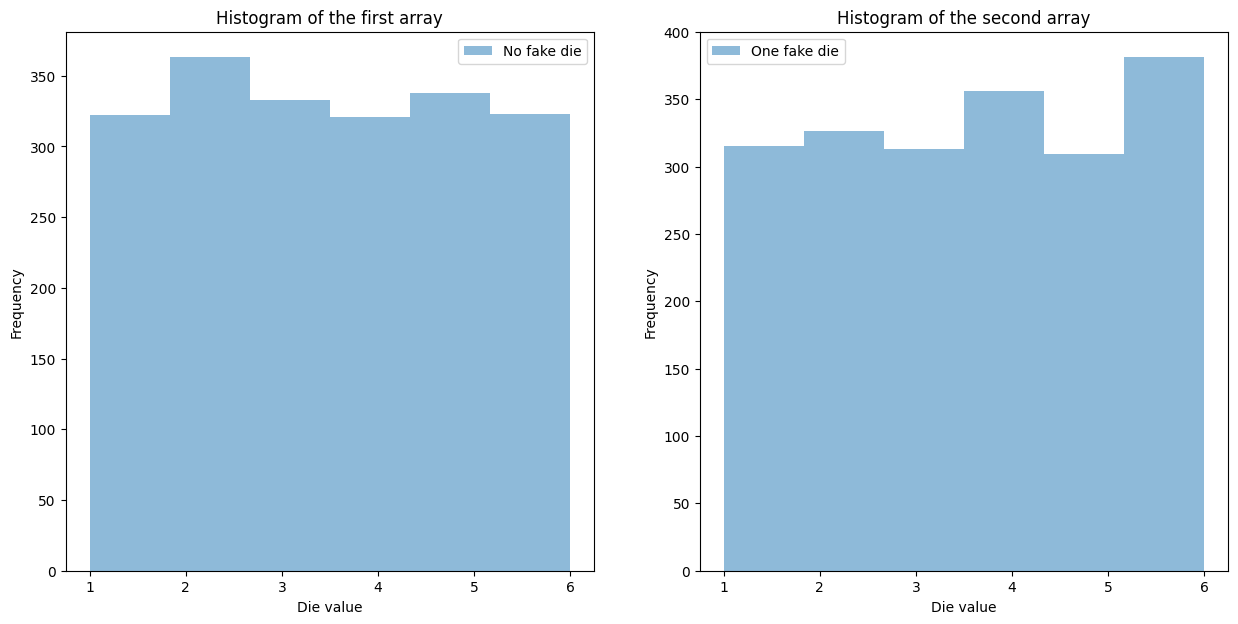

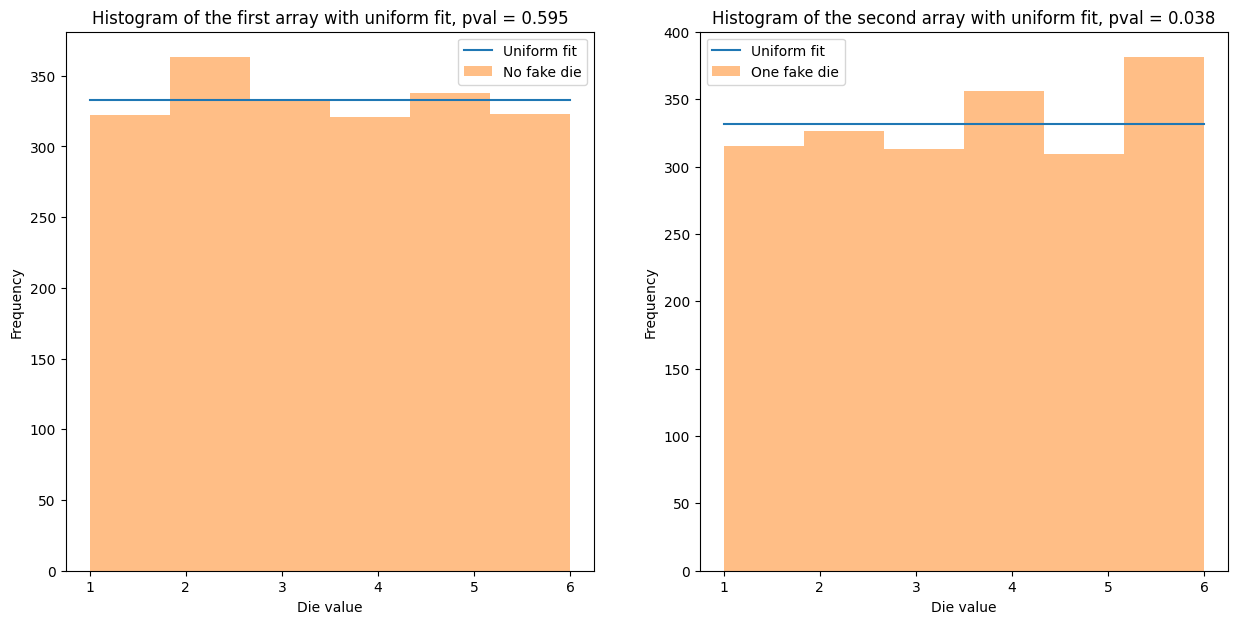

We can safely say that the second array is fake, as it is definitely not uniformly distributed. Therefore we don't need to do anymore rolls


In [208]:
r.seed(r.randint(1,int(100)))
fig,ax = plt.subplots(1,2,figsize = (15,7))
nofakevals = nofakedie(100)
fakevals = onefakedie(100)
ax[0].hist(nofakevals, bins = 6,alpha=0.5, label='No fake die')
ax[0].legend()
ax[0].set_title('Histogram of the first array')
ax[0].set_xlabel('Die value')
ax[0].set_ylabel('Frequency')
ax[1].hist(fakevals, bins = 6,alpha=0.5, label='One fake die')
ax[1].legend()
ax[1].set_title('Histogram of the second array')
ax[1].set_xlabel('Die value')
ax[1].set_ylabel('Frequency')
plt.show()
countsnofake,binsnofake = np.histogram(nofakevals, bins=6)
countsfake,binsfake = np.histogram(fakevals, bins=6)
binsnofake = (binsnofake[1:] + binsnofake[:-1])/2
binsfake = (binsfake[1:] + binsfake[:-1])/2
uninofake = LeastSquares(binsnofake, countsnofake, np.sqrt(countsnofake), uniformfit)
mno = Minuit(uninofake,N = 100)
mno.migrad()
unifake = LeastSquares(binsfake, countsfake, np.sqrt(countsfake), uniformfit)
mfa = Minuit(unifake,N = 100)
mfa.migrad()
binspace = np.linspace(1, 6, 10)
fig,ax = plt.subplots(1,2,figsize = (15,7))
preal = stats.chi2.sf(mno.fval, len(binsnofake)-1)
pfake = stats.chi2.sf(mfa.fval, len(binsfake)-1)
ax[0].plot(binspace, uniformfit(binspace, *mno.values), label='Uniform fit')
ax[0].hist(nofakevals, bins=6, alpha=0.5,label='No fake die')
ax[0].legend()
ax[0].set_title(f'Histogram of the first array with uniform fit, pval = {preal:.3f}')
ax[0].set_xlabel('Die value')
ax[0].set_ylabel('Frequency')
ax[1].plot(binspace, uniformfit(binspace, *mfa.values), label='Uniform fit')
ax[1].hist(fakevals, bins=6, alpha=0.5,label='One fake die')
ax[1].legend()
ax[1].set_title(f'Histogram of the second array with uniform fit, pval = {pfake:.3f}')
ax[1].set_xlabel('Die value')
ax[1].set_ylabel('Frequency')
plt.show()

#Ignoring the somewhat obvious peak at 6 when we know which histogram is what, we can see that the two histograms are very similar, and thus we can't really tell if the die is fake or not
print("We can safely say that the second array is fake, as it is definitely not uniformly distributed. Therefore we don't need to do anymore rolls")

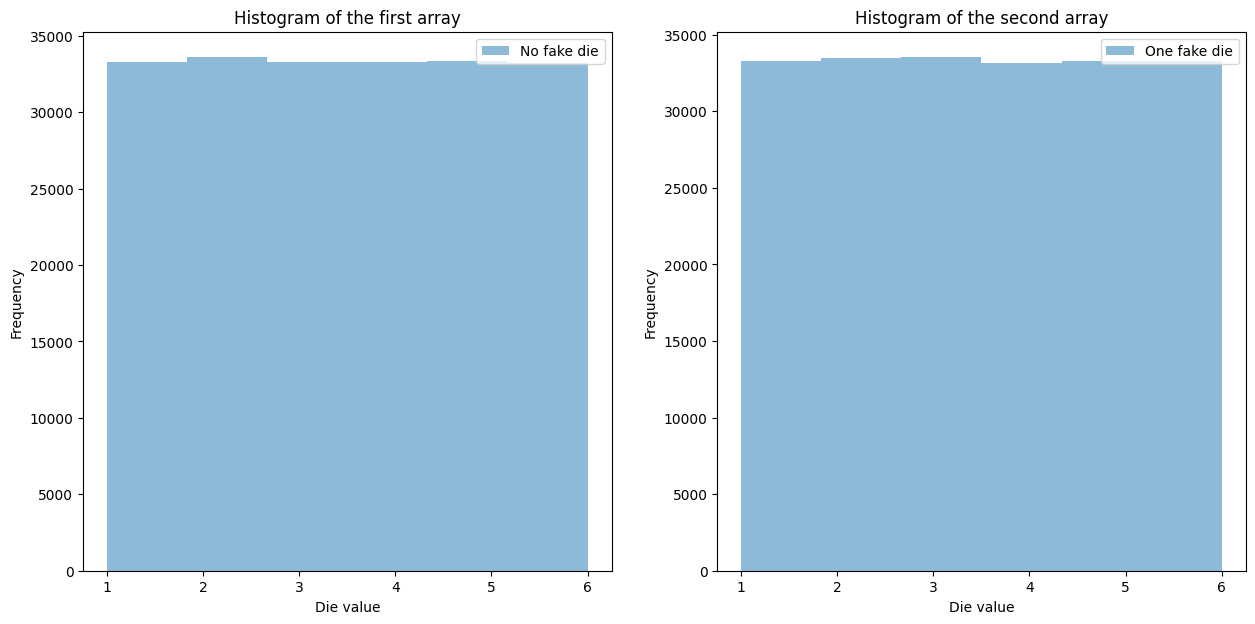

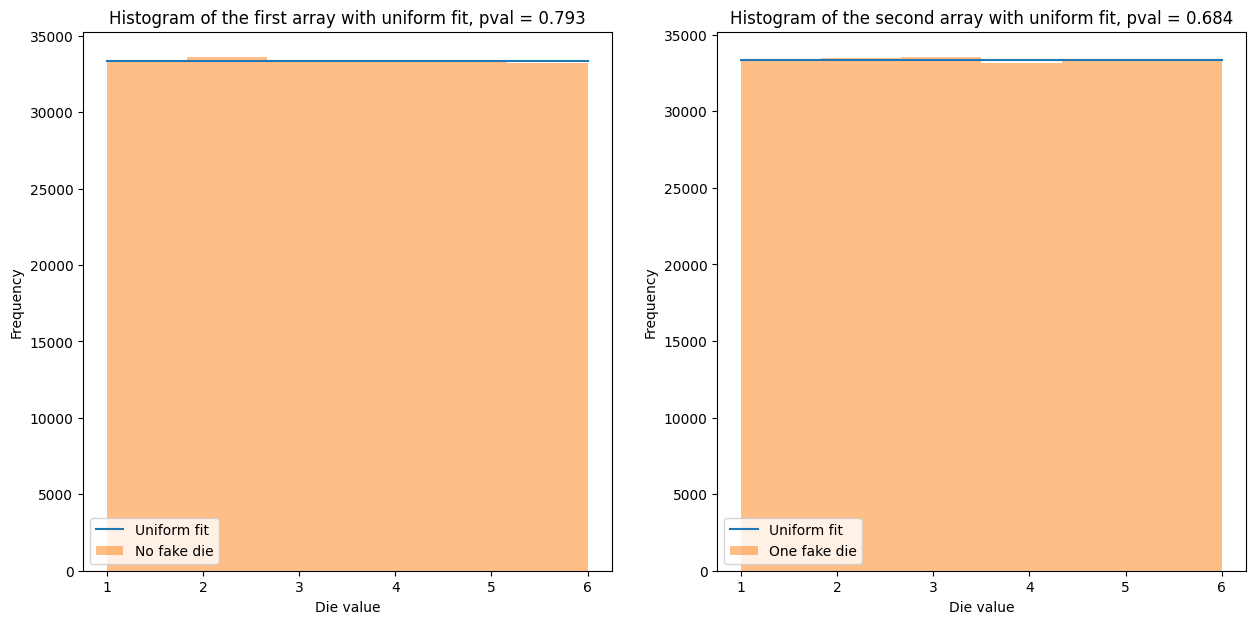

Okay, so now we can't tell which is which just from a linear fit


In [209]:
#Now lets assume there are more die, maybe 2000, and we have to find the fake die
dieamount = 2000
throws = 100
fig,ax = plt.subplots(1,2,figsize = (15,7))
nofakevals = nofakedie(throws,dieamount)
fakevals = onefakedie(throws,dieamount)
ax[0].hist(nofakevals, bins = 6,alpha=0.5, label='No fake die')
ax[0].legend()
ax[0].set_title('Histogram of the first array')
ax[0].set_xlabel('Die value')
ax[0].set_ylabel('Frequency')
ax[1].hist(fakevals, bins = 6,alpha=0.5, label='One fake die')
ax[1].legend()
ax[1].set_title('Histogram of the second array')
ax[1].set_xlabel('Die value')
ax[1].set_ylabel('Frequency')
plt.show()
countsnofake,binsnofake = np.histogram(nofakevals, bins=6)
countsfake,binsfake = np.histogram(fakevals, bins=6)
binsnofake = (binsnofake[1:] + binsnofake[:-1])/2
binsfake = (binsfake[1:] + binsfake[:-1])/2
uninofake = LeastSquares(binsnofake, countsnofake, np.sqrt(countsnofake), uniformfit)
mno = Minuit(uninofake,N = 100)
mno.migrad()
unifake = LeastSquares(binsfake, countsfake, np.sqrt(countsfake), uniformfit)
mfa = Minuit(unifake,N = 100)
mfa.migrad()
binspace = np.linspace(1, 6, 10)
fig,ax = plt.subplots(1,2,figsize = (15,7))
preal = stats.chi2.sf(mno.fval, len(binsnofake)-1)
pfake = stats.chi2.sf(mfa.fval, len(binsfake)-1)
ax[0].plot(binspace, uniformfit(binspace, *mno.values), label='Uniform fit')
ax[0].hist(nofakevals, bins=6, alpha=0.5,label='No fake die')
ax[0].legend()
ax[0].set_title(f'Histogram of the first array with uniform fit, pval = {preal:.3f}')
ax[0].set_xlabel('Die value')
ax[0].set_ylabel('Frequency')
ax[1].plot(binspace, uniformfit(binspace, *mfa.values), label='Uniform fit')
ax[1].hist(fakevals, bins=6, alpha=0.5,label='One fake die')
ax[1].legend()
ax[1].set_title(f'Histogram of the second array with uniform fit, pval = {pfake:.3f}')
ax[1].set_xlabel('Die value')
ax[1].set_ylabel('Frequency')
plt.show()
print("Okay, so now we can't tell which is which just from a linear fit")

Let's try plotting the amount of eyes on the die per throw
This didn't give any clear results, so we can't really tell which die is fake


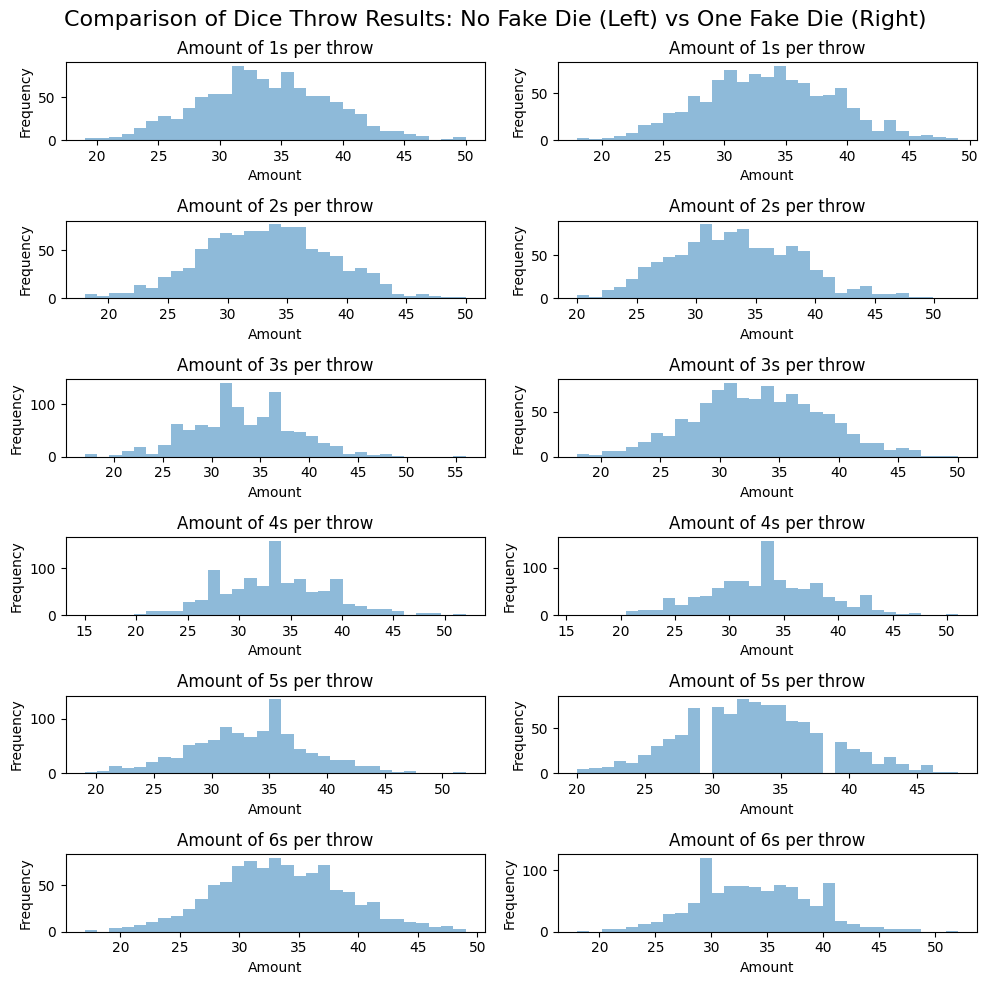

In [ ]:
#Lets try and throw them some more and see what happens
throws = 1000
dieamount = 200
nofakevals = nofakedie(throws,dieamount)
fakevals = onefakedie(throws,dieamount)
Array1 = np.copy(nofakevals)
Array2 = np.copy(fakevals)
Array1sum = [np.sum(Array1[i:i+dieamount]) for i in range(0,len(Array1),dieamount)]
Array2sum = [np.sum(Array2[i:i+dieamount]) for i in range(0,len(Array2),dieamount)]
plt.hist(Array1sum, bins=20, alpha=0.5, label='No fake die')
plt.hist(Array2sum, bins=20, alpha=0.5, label='One fake die')
plt.xlabel("Sum of total amount of eyes on die per throw")
plt.ylabel('Frequency')
plt.legend()
plt.close()
print("Let's try plotting the amount of eyes on the die per throw")
def amount_eyes(array,dieamount):
    counts = []
    for i in range(throws):
        throw_vals = array[i*dieamount : (i+1)*dieamount]  
        count = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}  
        for val in throw_vals:
            count[val] += 1
        counts.append([count[1], count[2], count[3], count[4], count[5], count[6]])
    return counts
counts1 = amount_eyes(Array1,dieamount)
counts2 = amount_eyes(Array2,dieamount)
fig,ax = plt.subplots(6,2,figsize = (10,10))
for i in range(6):
    ax[i,0].hist([count[i] for count in counts1], bins=int(np.sqrt(len(counts1))), alpha=0.5, label='No fake die')
    ax[i,1].hist([count[i] for count in counts2], bins=int(np.sqrt(len(counts1))), alpha=0.5, label='One fake die')
    ax[i,0].set_title(f'Amount of {i+1}s per throw')
    ax[i,1].set_title(f'Amount of {i+1}s per throw')
    ax[i,0].set_xlabel('Amount')
    ax[i,1].set_xlabel('Amount')
    ax[i,0].set_ylabel('Frequency')
    ax[i,1].set_ylabel('Frequency')
fig.suptitle('Comparison of Dice Throw Results: No Fake Die (Left) vs One Fake Die (Right)', fontsize=16)
fig.tight_layout()
print("This didn't give any clear results, so we can't really tell which die is fake")

In [135]:
# #What about the sum of all the different types of eyes, then plotting? Should be roughly uniform or the same. If there is a clear outlier then that must be the fake die
throws = 10000
dieamount = 200
nofakevals = nofakedie(throws,dieamount)
fakevals = onefakedie(throws,dieamount)
Array1 = np.copy(nofakevals)
Array2 = np.copy(fakevals)
freq1 = np.array([np.sum(Array1 == i) for i in range(1, 7)])
freq2 = np.array([np.sum(Array2 == i) for i in range(1, 7)])
mean1 = np.array([np.mean(Array1 == i) for i in range(1,7)])
std1 = np.array([np.std(Array1 == i)/np.sqrt((freq1[i-1])) for i in range(1,7)])
mean2 = np.array([np.mean(Array2 == i) for i in range(1,7)])
std2 = np.array([np.std(Array2 == i)/np.sqrt((freq2[i-1])) for i in range(1,7)])
expected = 1/6
print((expected-mean1)/std1)
print((expected-mean2)/std2)
#Its rather clear here that there is a significant outlier in the second array, and thus we can conclude that the second array is the fake die

[-0.30884281 -0.29644636  0.14819766  0.48583888  0.44712304 -0.47620657]
[ 1.05173198  1.17014334  1.26378124  1.15466535  1.6274343  -6.28616222]


# 5.1 Færdig

[19 15 14 14  9 22 14 13 16 16 14 11 13  5 13 16 18 12 10 12 14 17 15 13
 15 14 17 13 10 15 10 13 10 14 10 17 14 12 10 11]


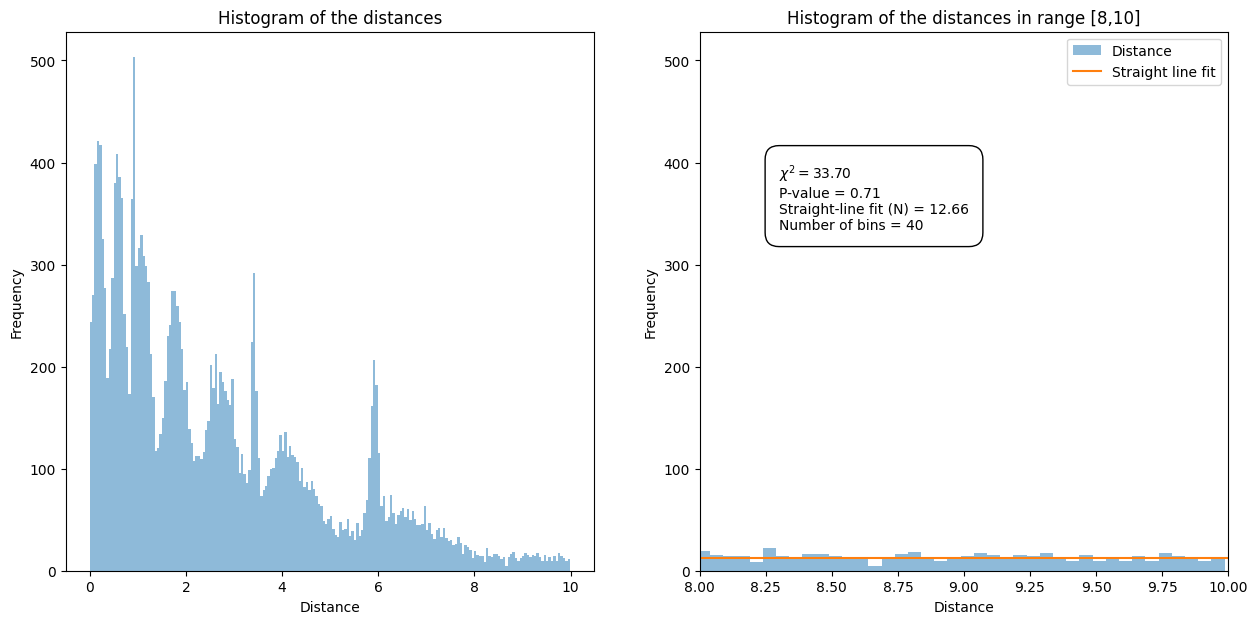

In [136]:
from scipy.stats import gamma
dataframe = pd.read_csv('data_InconstantBackground.csv', header=0)
dataframe
distance = dataframe['# Distance'] # in nm
def uniformfit(x,N):
    return N+x-x
counts,bins = np.histogram(distance, bins=200)
bins = (bins[1:] + bins[:-1])/2
zeromask = counts > 0
binrangemask = (bins >= 8) & (bins <= 10)
bins = bins[zeromask & binrangemask]
counts = counts[zeromask & binrangemask]
binspace = np.linspace(8, 10, 10)
print(counts)
unifit = LeastSquares(bins, counts, np.sqrt(counts), uniformfit)
m1 = Minuit(unifit,N = 20)
m1.migrad()
pval = 1-stats.chi2.cdf(m1.fval, len(bins)-1)
fig,ax = plt.subplots(1,2,figsize = (15,7))
ax[0].hist(distance, bins=200, alpha=0.5, label='Distance')
ax[0].set_title('Histogram of the distances')
ax[0].set_xlabel('Distance')
ax[0].set_ylabel('Frequency')
ax[1].hist(distance, bins=200, alpha=0.5, label='Distance')
ax[1].set_title('Histogram of the distances in range [8,10]')
ax[1].set_xlabel('Distance')
ax[1].set_ylabel('Frequency')
ax[1].plot(binspace, uniformfit(binspace, *m1.values), label='Straight line fit')
ax[1].legend()
textstr = '\n'.join((
    f'$\chi^2 = {m1.fval:.2f}$',
    f'P-value = {pval:.2f}',
    f'Straight-line fit (N) = {m1.values[0]:.2f}',
    f'Number of bins = {len(bins)}'
))
ax[1].text(8.3, 400, textstr, transform=ax[1].transData,
           fontsize=10, verticalalignment='top',
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
ax[1].set_xlim(8,10)

plt.show()
background = m1.values['N']

#so we can't deny that its uniform in this range

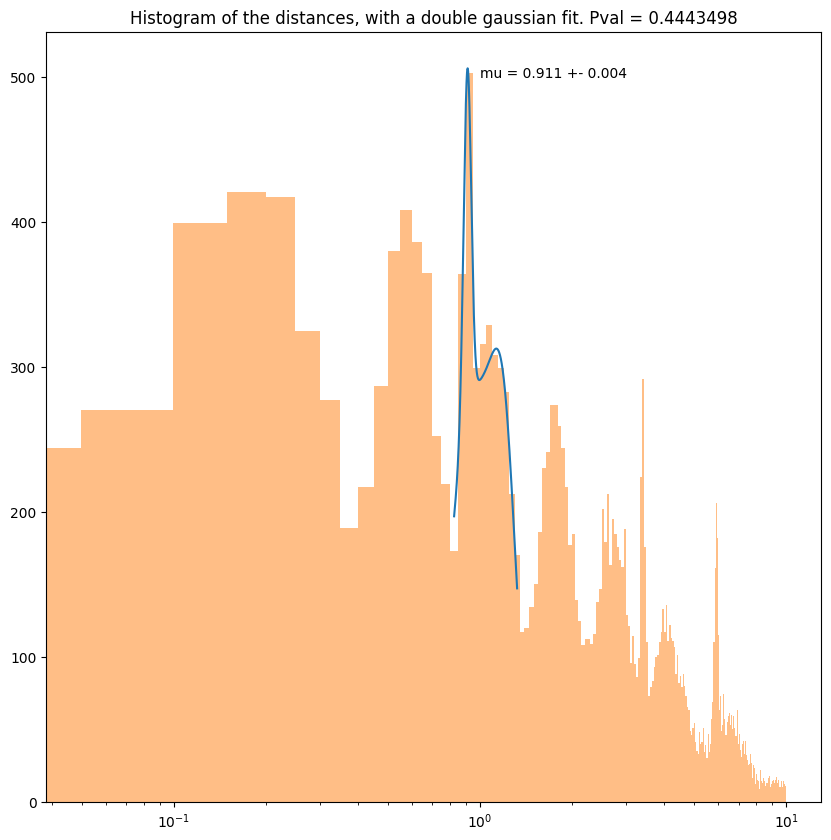

In [137]:
#We can use the background from before
def lintwogaus(x, mu1, sigma1, N,f,sigma2,a,b):
    return N*(f*norm.pdf(x, mu1, sigma1)+(1-f)*norm.pdf(x,mu1,sigma2)) +background+a*x*N
def lintwogaus2(x, mu1, mu2,sigma1, N,f,sigma2):
    return N*(f*norm.pdf(x, mu1, sigma1)+(1-f)*norm.pdf(x,mu2,sigma2)+(1-f)**2*norm.pdf(x,mu1,sigma2)) +background
binnumber = 200
counts,bins = np.histogram(distance, bins=binnumber)
bins = (bins[1:] + bins[:-1])/2
zeromask = counts > 0
bins = bins[zeromask]
counts = counts[zeromask]
binwidth = bins[1]-bins[0]
binrange1mask = (bins >= 0.8) & (bins <= 1.37)
binrange2mask = (bins >= 3 ) & (bins <= 4)
binrange3mask = (bins >=5.1) & (bins <= 7)
bins1 = bins[binrange1mask]
counts1 = counts[binrange1mask]
bins2 = bins[binrange2mask]
counts2 = counts[binrange2mask]
bins3 = bins[binrange3mask]
counts3 = counts[binrange3mask]
binspace1 = np.linspace(min(bins1), max(bins1), 10000)
binspace2 = np.linspace(min(bins2), max(bins2), 10000)
binspace3 = np.linspace(min(bins3), max(bins3), 10000)
chi2fit = LeastSquares(bins1, counts1,np.sqrt(counts1), lintwogaus2)
m11 = Minuit(chi2fit, mu1 = 0.9,sigma1 = 0.001,N = 200,f = 0.3,mu2 = 1.2,sigma2 = 0.4)
m11.limits['mu1'] = (0.88, 91)
m11.limits['mu2'] = (1, 1.3)
m11.limits['sigma1'] = (0.01, 1)
m11.limits['N'] = (0, 100)
m11.limits['f'] = (0,1)
m11.migrad()
pval11 = stats.chi2.sf(m11.fval, len(bins2)-6)
plt.plot(binspace1, lintwogaus2(binspace1, *m11.values), label='Fit')
plt.hist(distance,bins=binnumber, alpha=0.5, label='Distance')
plt.title(f'Histogram of the distances, with a double gaussian fit. Pval = {pval11:.7f}')
plt.xscale('log')
plt.text(1, 500, f"mu = {m11.values['mu1']:.3f} +- {m11.errors['mu1']:.3f}")

plt.show()


<ValueView mu1=3.4154381801819005 mu2=3.0000873723729677 sigma1=0.045588635850915216 N=99.8226859547577 f=0.24749499209767878 sigma2=0.6071031611611087 a=3.399995397940656 b=2.89018097028455 c=-0.028773316833745545>


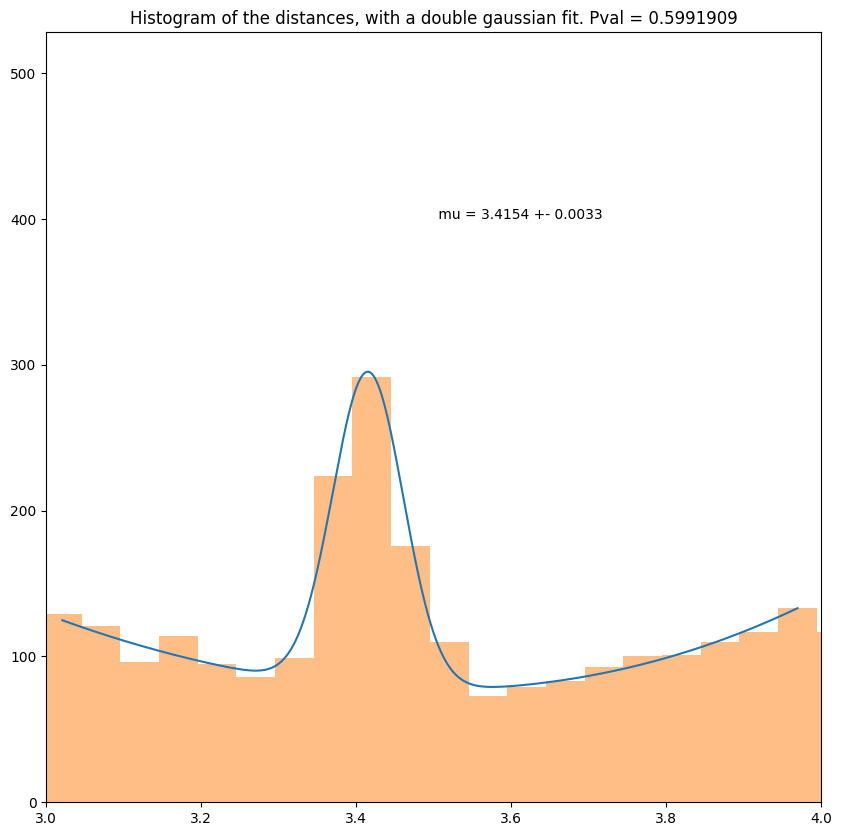

In [138]:
def lintwogaus3_with_parabolic_background(x, mu1, mu2, sigma1, N, f, sigma2, a,b,c):
    backgroundterm =  b * (x - a)**2 +c*x #+  a*(x - mu1)**2
    
    gaussian_components =  (
        f * norm.pdf(x, mu1, sigma1) + 
        (1 - f) * norm.pdf(x, mu2, sigma2) + 
        (1 - f)**2  * norm.pdf(x, mu1, sigma2)
    )
    
    return N*(gaussian_components + backgroundterm)+background

chi2fit = LeastSquares(bins2, counts2,np.sqrt(counts2), lintwogaus3_with_parabolic_background)
m12 = Minuit(chi2fit, mu1 = 3.41,mu2 = 3.4,sigma1 = 0.1,N = binwidth*counts2.sum(),f = 0.5,sigma2 = 0.4,a = 3.4,b = 2,c = 0.2)
m12.limits['mu1'] = (3.35, 3.45)
m12.limits['mu2'] = (3, 3.4)
m12.limits['sigma1'] = (0, None)
m12.limits['N'] = (0, 100)
m12.limits['f'] = (0,1)
m12.limits['a'] = (3.2,3.4)
m12.migrad()
print(m12.values)

pval12 = stats.chi2.sf(m12.fval, len(bins2)-9)
plt.plot(binspace2, lintwogaus3_with_parabolic_background(binspace2, *m12.values), label='Fit')
plt.hist(distance,bins=binnumber, alpha=0.5, label='Distance')
plt.title(f'Histogram of the distances, with a double gaussian fit. Pval = {pval12:.7f}')
plt.text(3.5, 400, f" mu = {m12.values['mu1']:.4f} +- {m12.errors['mu1']:.4f}")
plt.xlim(3,4)
plt.show()


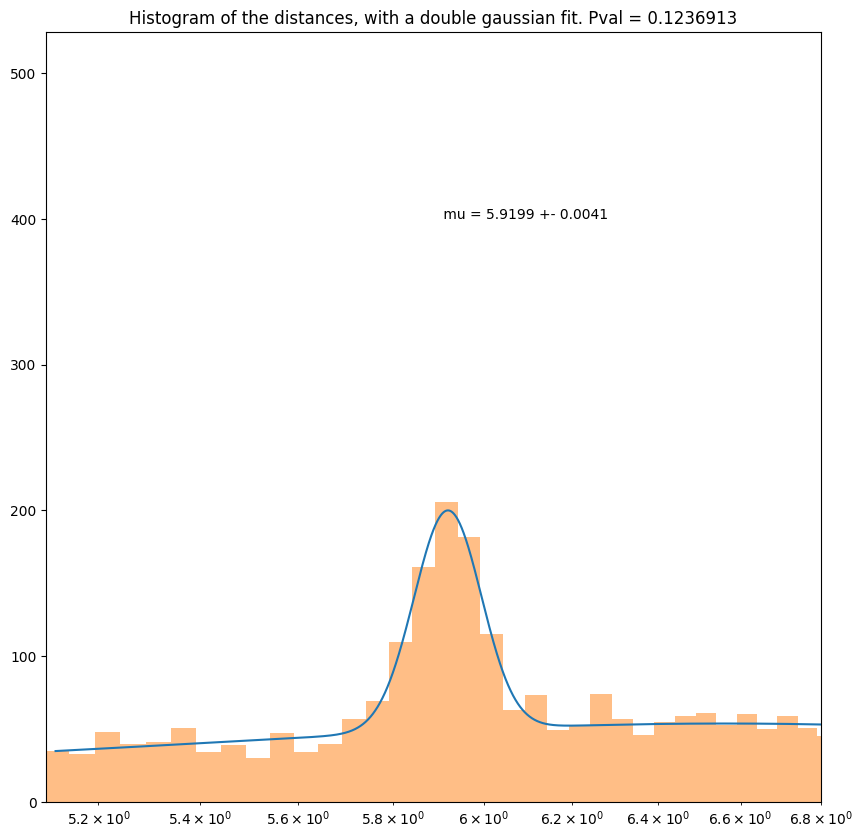

In [139]:
def lintwogaus(x, mu1,mu2, sigma1,sigma2,N,f,a):
    return N*((1 - f) * norm.pdf(x, mu2, sigma2) + 
        (1 - f)**2  * norm.pdf(x, mu1, sigma2)
    +x*a) +background

def lintwogausfr(x, mu1,mu2, sigma1,sigma2,N,f,a): #bismillah this one works
    return N*(( f) * norm.pdf(x, mu2, sigma2) + 
        (1 - f)  * norm.pdf(x, mu1, sigma2)
    +a*np.exp(-0.5 * ((x - mu1) / sigma1)**2) ) + background 
chi2fit = LeastSquares(bins3, counts3,np.sqrt(counts3), lintwogausfr)
m13 = Minuit(chi2fit, mu1 = 5.9,mu2 = 5.9,sigma1 = 0.01,sigma2 = 1,N = binwidth*counts2.sum(),a = 0.1,f = 0.1)
m13.limits['mu1'] = (5.8, 6.1)
m13.limits['sigma1'] = (0, None)
m13.limits['N'] = (0, None)
m13.limits['f'] = (0,1)
m13.migrad()
pval13 = stats.chi2.sf(m13.fval, len(bins3)-7)
plt.plot(binspace3, lintwogausfr(binspace3, *m13.values), label='Fit')
plt.hist(distance,bins=binnumber, alpha=0.5, label='Distance')
plt.title(f'Histogram of the distances, with a double gaussian fit. Pval = {pval13:.7f}')
plt.xscale('log')
plt.xlim(5.1,6.8)
plt.text(5.9, 400, f" mu = {m13.values['mu1']:.4f} +- {m13.errors['mu1']:.4f}")

plt.show()


Text(0, 0.5, 'Frequency')

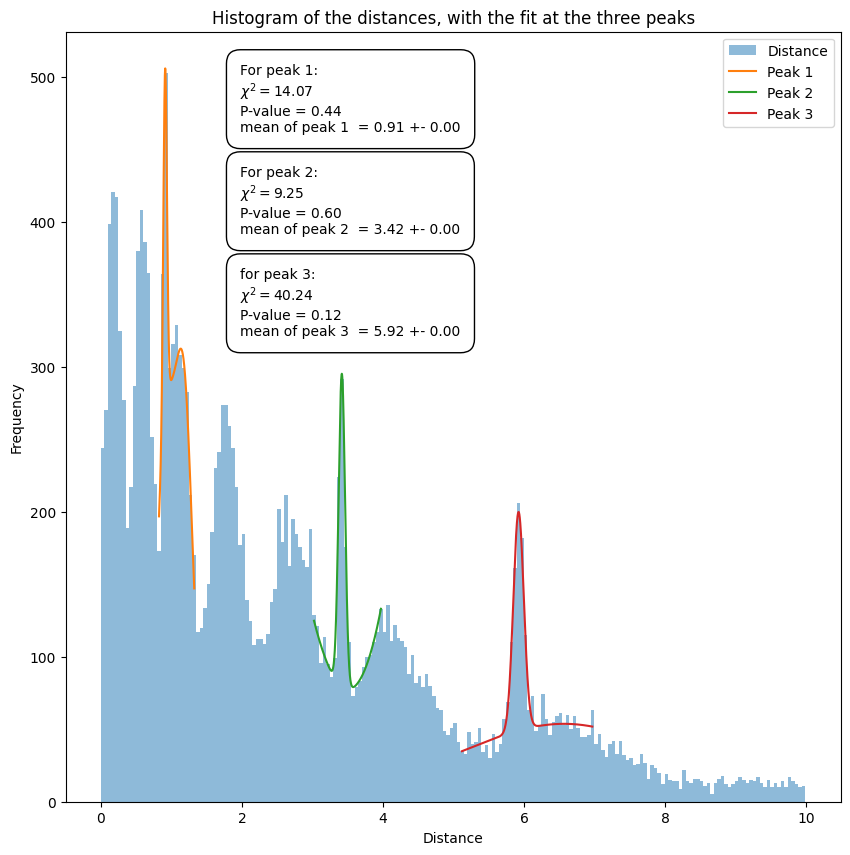

In [140]:
plt.hist(distance,bins=binnumber, alpha=0.5, label='Distance')
plt.plot(binspace1, lintwogaus2(binspace1, *m11.values), label='Peak 1')
plt.plot(binspace2, lintwogaus3_with_parabolic_background(binspace2, *m12.values), label='Peak 2')
plt.plot(binspace3, lintwogausfr(binspace3, *m13.values), label='Peak 3')
textstr = '\n'.join((
    'For peak 1: ',
    f'$\chi^2 = {m11.fval:.2f}$',
    f'P-value = {pval11:.2f}',
    f'mean of peak 1  = {m11.values["mu1"]:.2f} +- {m11.errors["mu1"]:.2f}',
))
plt.text(5.8, 700, textstr, transform=ax[1].transData,
           fontsize=10, verticalalignment='top',
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
textstr2 = '\n'.join((
    'For peak 2: ',
    f'$\chi^2 = {m12.fval:.2f}$',
    f'P-value = {pval12:.2f}',
    f'mean of peak 2  = {m12.values["mu1"]:.2f} +- {m12.errors["mu1"]:.2f}',
))
plt.text(5.8, 600, textstr2, transform=ax[1].transData, 
              fontsize=10, verticalalignment='top',
              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
textstr3 = '\n'.join(( 
    'for peak 3: ',
    f'$\chi^2 = {m13.fval:.2f}$',
    f'P-value = {pval13:.2f}',
    f'mean of peak 3  = {m13.values["mu1"]:.2f} +- {m13.errors["mu1"]:.2f}',
))
plt.text(5.8, 500, textstr3, transform=ax[1].transData,
              fontsize=10, verticalalignment='top',
              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.title(f'Histogram of the distances, with the fit at the three peaks')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Frequency')

The first peak is at 0.911 with a standard deviation of 0.026
The second peak is at 3.000 with a standard deviation of 0.046
The third peak is at 5.920 with a standard deviation of 0.074
The total amount of measurements in the first peak is 867 +- 29.444863728670914
The total amount of measurements in the second peak is 600 +- 24.49489742783178
The total amount of measurements in the third peak is 837 +- 28.930952282978865
Assuming poisson statistics, we take the squareroot of the amount of counts as the error


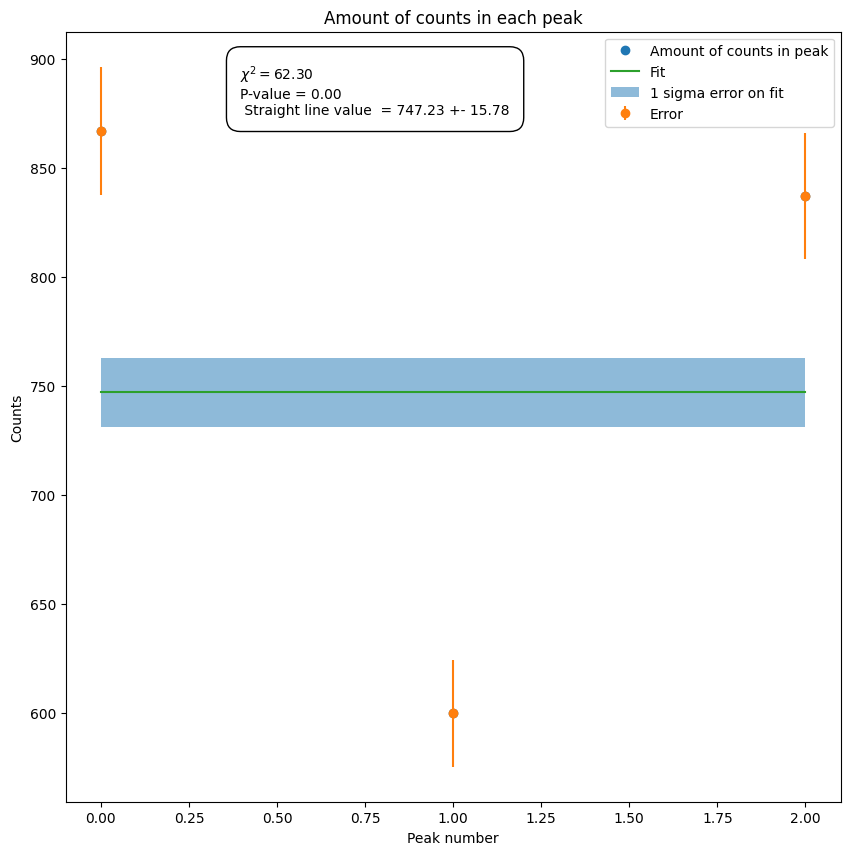

In [141]:
mu1 = m11.values['mu1']
mu2 = m12.values['mu2']
mu3 = m13.values['mu1']
#As such the results are
print(f"The first peak is at {mu1:.3f} with a standard deviation of {m11.values['sigma1']:.3f}")
print(f"The second peak is at {mu2:.3f} with a standard deviation of {m12.values['sigma1']:.3f}")
print(f"The third peak is at {mu3:.3f} with a standard deviation of {m13.values['sigma1']:.3f}")

N1 = m11.values['N']
N2 = m12.values['N']
N3 = m13.values['N']
mu1mask = (bins >= mu1-2*m11.values['sigma1']) & (bins <= mu1+2*m11.values['sigma1'])
mu2mask = (bins >= mu2-2*m12.values['sigma1']) & (bins <= mu2+2*m12.values['sigma1'])
mu3mask = (bins >= mu3-2*m13.values['sigma1']) & (bins <= mu3+2*m13.values['sigma1'])
print("The total amount of measurements in the first peak is",np.sum(counts[mu1mask]), "+-",np.sqrt(np.sum(counts[mu1mask])))
print("The total amount of measurements in the second peak is",np.sum(counts[mu2mask]), "+-",np.sqrt(np.sum(counts[mu2mask])))
print("The total amount of measurements in the third peak is",np.sum(counts[mu3mask]) , "+-",np.sqrt(np.sum(counts[mu3mask])))
print("Assuming poisson statistics, we take the squareroot of the amount of counts as the error")
signalvals = np.array([np.sum(counts[mu1mask]),np.sum(counts[mu2mask]),np.sum(counts[mu3mask])])
signalerrs = np.sqrt(signalvals)
plt.plot(signalvals, 'o', label='Amount of counts in peak')
plt.errorbar(np.arange(3),signalvals, yerr = signalerrs, fmt = 'o', label='Error')
chi2uniform = LeastSquares(np.arange(3),signalvals,signalerrs,uniformfit)
m14 = Minuit(chi2uniform,N = 100)
m14.migrad()
pval14 = stats.chi2.sf(m14.fval, len(signalvals)-1)
textstr = '\n'.join((
    f'$\chi^2 = {m14.fval:.2f}$',
    f'P-value = {pval14:.2f}',
    f' Straight line value  = {m14.values[0]:.2f} +- {m14.errors[0]:.2f}',
))
plt.text(5.8, 700, textstr, transform=ax[1].transData,
           fontsize=10, verticalalignment='top',
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.plot(np.arange(3),uniformfit(np.arange(3),*m14.values), label='Fit')
plt.fill_between(np.arange(3), m14.values[0]-m14.errors[0], m14.values[0]+m14.errors[0], alpha=0.5, label='1 sigma error on fit')
plt.title(f"Amount of counts in each peak")
plt.xlabel("Peak number")
plt.ylabel("Counts")
plt.legend()
plt.show()


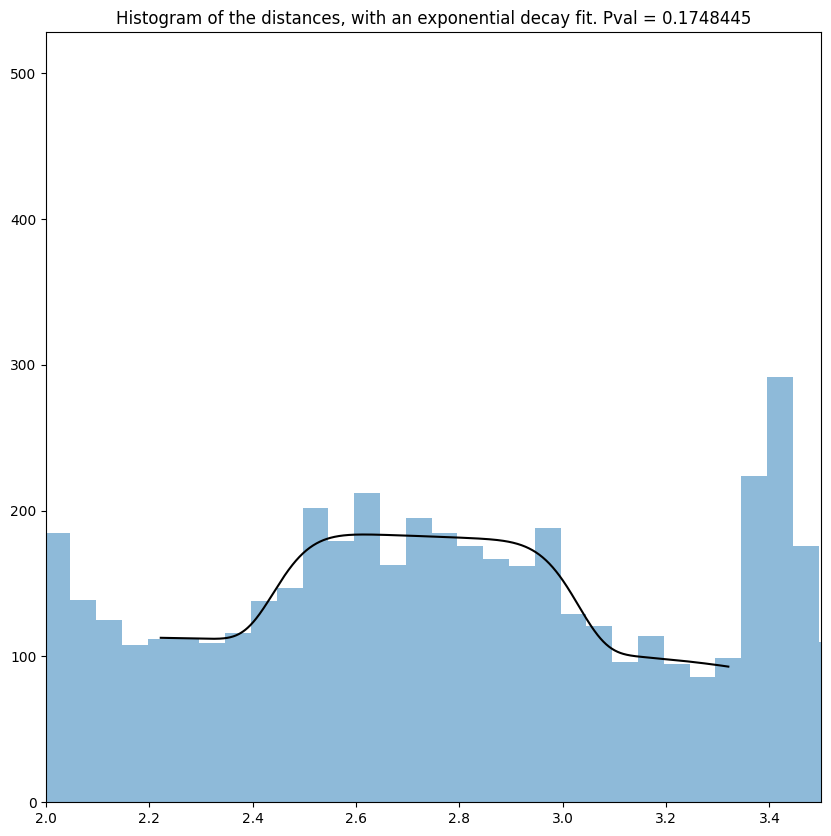

In [142]:
#Okay now to fit the WHOLE F**** THING
#I'm going to do a piecewise function for this, since it seems like the best way. We already have three of the peaks.
#We need to fit from [0,10]. We already have the functions in the area [0.83,1.37], [3,4] and [5.1,7]
#So we are missing the functions in the area [0,0.83], [1.37,3] and [4,5.1] and [7,10]
#Let's start with [7,10] as it looks like a simple exponential decay
def expodecay(x,N,a,b):
    return x * a * np.exp(-x * (a + b * x)) * N+background

def twogaus(x, mu1,mu2, sigma1,sigma2,N,f):
    return N*((1 - f) * norm.pdf(x, mu2, sigma2) + 
        (1 - f)**2  * norm.pdf(x, mu1, sigma2)
    ) +background

def gaussweighttail(x, mu1,mu2, sigma1,sigma2,w1,w2,N,f):
    def generalized_gaussian(x, mu, sigma, w):
        return np.exp(-0.5 * ((np.abs(x - mu) / sigma) ** w)) / (sigma * np.sqrt(2 * np.pi))
    
    return N * ((1-f)*generalized_gaussian(x, mu2, sigma2, w2) + 
                (1-f)**2*generalized_gaussian(x, mu1, sigma1, w1)) + background
binnumber = 200
binrange7mask = (bins >=6.7)
counts,bins = np.histogram(distance, bins=binnumber)
bins = (bins[1:] + bins[:-1])/2
zeromask = counts > 0
bins = bins[zeromask]
counts = counts[zeromask]
binwidth = bins[1]-bins[0]
counts7 = counts[binrange7mask]
bins7 = bins[binrange7mask]
binspace7 = np.linspace(min(bins7), max(bins7), 1000)

chi2fit = LeastSquares(bins7, counts7,np.sqrt(counts7), expodecay)
m15 = Minuit(chi2fit,N = 100,a = 0.1,b = 0.1)
m15.limits['N'] = (0, None)
m15.limits['a'] = (0, None)
m15.migrad()
pval15 = stats.chi2.sf(m15.fval, len(bins7)-3)
#Great, now we have exponential decay. Now we need to fit the rest of the peaks at [0,0.83], [1.37,3] and [4,5.1]
binrange4mask = (bins <= 0.82) & (bins >= 0.05)
binrange5mask = (bins >= 1.38) & (bins <= 2.2)
binrange6mask = (bins >= 2.2) & (bins <= 3.35)
binrange8mask = (bins >= 3.5) & (bins <= 5.1)
counts6 = counts[binrange6mask]
bins6 = bins[binrange6mask]
binspace6 = np.linspace(min(bins6), max(bins6), 1000)
counts5 = counts[binrange5mask]
bins5 = bins[binrange5mask]
binspace5 = np.linspace(min(bins5), max(bins5), 1000)
counts4 = counts[binrange4mask]
bins4 = bins[binrange4mask]
counts8 = counts[binrange8mask]
bins8 = bins[binrange8mask]
binspace8 = np.linspace(min(bins8), max(bins8), 1000)
binspace4 = np.linspace(-0.01, max(bins4), 1000)

chi2fit = LeastSquares(bins4, counts4,np.sqrt(counts4), gaussweighttail)
m16 = Minuit(chi2fit,mu1 = 0.15,mu2 = 0.5,sigma1 = 0.1,sigma2 = 0.1,N = binwidth*counts4.sum(),f = 0.1,w1 = 0.1,w2 = 0.2)
m16.limits['sigma1'] = (0, None)
m16.limits['sigma2'] = (0, None)
m16.limits['N'] = (0, None)
m16.limits['f'] = (0,1)
m16.migrad()
pval16 = stats.chi2.sf(m16.fval, len(bins4)-8)

plt.hist(distance,bins=binnumber, alpha=0.5, label='Distance')
chi2fit = LeastSquares(bins5, counts5,np.sqrt(counts5), twogaus)
m17 = Minuit(chi2fit,mu1 = 1.6,mu2 = 2.8,sigma1 = 0.04,sigma2 = 0.05,N = binwidth*counts5.sum(),f = 0.999)
m17.limits['N'] = (0, None)
m17.limits['f'] = (0,1)
m17.migrad()
pval17 = stats.chi2.sf(m17.fval, len(bins5)-6)

chi2fit = LeastSquares(bins6, counts6,np.sqrt(counts6), gaussweighttail)
m18 = Minuit(chi2fit,mu1 = 2.5,mu2 = 4,sigma1 = 0.5,sigma2 = 0.1,N = binwidth*counts6.sum(),f = 0.5,w1 = 0.2,w2 = .2)
m18.limits['sigma1'] = (0, None)
m18.limits['sigma2'] = (0, None)
m18.limits['N'] = (0, None)
m18.limits['f'] = (0,1)
m18.migrad()
pval18 = stats.chi2.sf(m18.fval, len(bins6)-6)
plt.title(f'Histogram of the distances, with an exponential decay fit. Pval = {pval18:.7f}')
plt.plot(binspace6, gaussweighttail(binspace6, *m18.values), color = "black",label='Fit') # [2.2,3.35]
plt.xlim(2,3.5)
chi2fit = LeastSquares(bins8, counts8,np.sqrt(counts8), twogaus)
m19 = Minuit(chi2fit,mu1 = 4.5,mu2 = 4.8,sigma1 = 0.1,sigma2 = 0.1,N = binwidth*counts8.sum(),f = 0.5)
m19.limits['sigma1'] = (0, None)
m19.limits['sigma2'] = (0, None)
m19.limits['N'] = (0, None)
m19.limits['f'] = (0,1)
m19.migrad()
pval19 = stats.chi2.sf(m19.fval, len(bins8)-6)
# plt.plot(binspace8, twogaus(binspace8, *m19.values), color = "black",label='Fit') # [4,5.1]
# plt.plot(binspace7, expodecay(binspace7, *m15.values), color = 'black',label='Fit') # [7,10]
# plt.plot(binspace3, lintwogausfr(binspace3, *m13.values), color = 'black',label='Fit') # [5.1,7]
# plt.plot(binspace4, twogaus(binspace4, *m16.values), color = "black",label='Fit') # [0,0.83]
# plt.plot(binspace2, lintwogaus3_with_parabolic_background(binspace2, *m12.values), color = 'black',label='Fit') # [3,4]
# plt.plot(binspace1, lintwogaus2(binspace1, *m11.values), color = 'black',label='Fit') # 0.83,1.37]
# plt.plot(binspace5, twogaus(binspace5, *m17.values), color = "black",label='Fit') # [1.37,2.2]
# plt.plot(binspace6, twogaus(binspace6, *m18.values), color = "black",label='Fit') # [2.2,3.35]
# #God i love this
# plt.title(f'Histogram of the distances, with a double gaussian fit. Pval = {pval19:.7f}')
# plt.show()


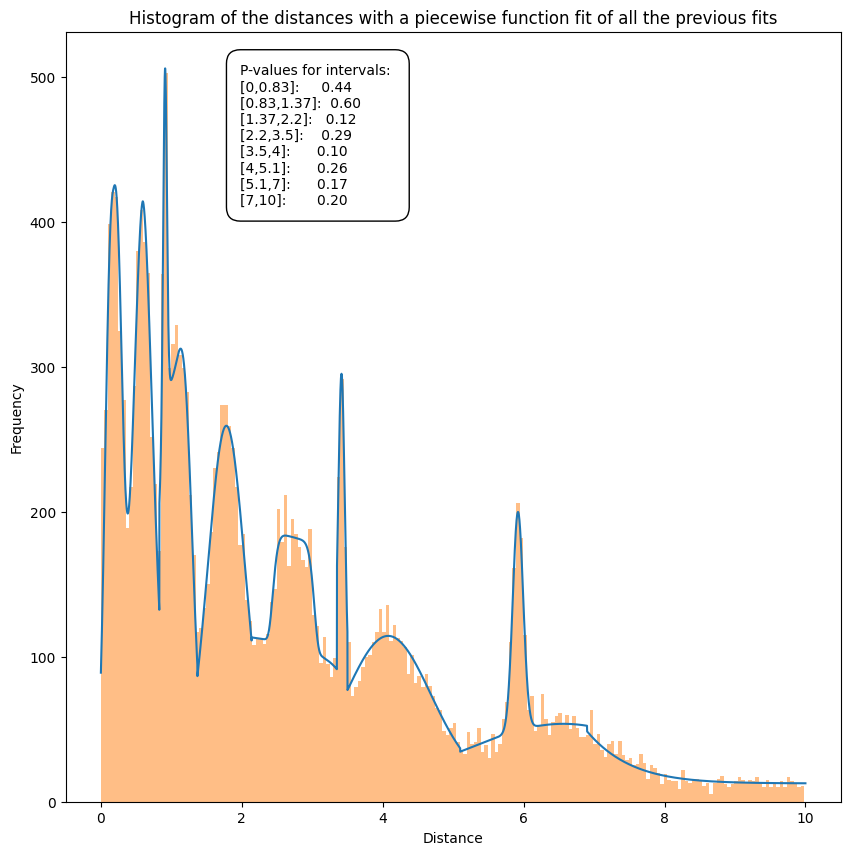

In [143]:
def piecewise_function(x):
    if x < 0 or x > 10:
        return 0  
    
    if 0 <= x <= 0.83:
        return gaussweighttail(x, *m16.values)  # [0, 0.83]
    elif 0.83 < x <= 1.37:
        return lintwogaus2(x, *m11.values)  # [0.83, 1.37]
    elif 1.37 < x <= 2.14:
        return twogaus(x, *m17.values)  # [1.37, 2.2]
    elif 2.13 < x <= 3.35:
        return gaussweighttail(x, *m18.values)  # [2.2, 3.35]
    elif 3 <= x <= 3.5:
        return lintwogaus3_with_parabolic_background(x, *m12.values)  # [3, 4]
    elif 3.5 < x <= 5.1:
        return twogaus(x, *m19.values)  # [4, 5.1]
    elif 5.1 < x <= 6.9:
        return lintwogausfr(x, *m13.values)  # [5.1, 7]
    elif 6.9 < x <= 10:
        return expodecay(x, *m15.values)  # [7, 10]
binspace = np.linspace(0, 10, 10000)
pvallist = [pval11,pval12,pval13,pval15,pval16,pval17,pval18,pval19]
#18
plt.plot(binspace, [piecewise_function(x) for x in binspace], label='Piecewise function')
plt.hist(distance, bins=binnumber, alpha=0.5, label='Distance')
plt.title('Histogram of the distances with a piecewise function fit of all the previous fits')
plt.xlabel('Distance')
plt.ylabel('Frequency')
textstr = '\n'.join((
    f'P-values for intervals: ',
    f'[0,0.83]:     {pval11:.2f}',
    f'[0.83,1.37]:  {pval12:.2f}',
    f'[1.37,2.2]:   {pval13:.2f}',
    f'[2.2,3.5]:    {pval15:.2f}',
    f'[3.5,4]:      {pval16:.2f}',
    f'[4,5.1]:      {pval17:.2f}',
    f'[5.1,7]:      {pval18:.2f}',
    f'[7,10]:       {pval19:.2f}'
))
plt.text(5.8, 700, textstr, transform=ax[1].transData,
           fontsize=10, verticalalignment='top',
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.show()


# 5.2 FÆRDIG ENDELIG YES

In [144]:
def linfunc(x,a,b):
    return a*x+b
alignyear = np.array([2600,2583,2572,2554,2522,2489,2446,2433]) #BC
east_align = np.array([-20.6,-17.3,-8.7,-3.4,6,12.4,23,30])
east_err = np.array([1,0.2,0.2,0.2,0.2,1,10,10])
west_align  =  np.array([-18.1,-11.8,np.nan,-2.8,6,14.1,np.nan,np.nan])
west_err = np.array([1,0.2,np.nan,0.2,0.2,1.8,np.nan,np.nan])
valid_idx = ~np.isnan(west_align) & ~np.isnan(west_err) & ~np.isnan(east_align) & ~np.isnan(east_err)
east_align2 = east_align[valid_idx]
east_err2 = east_err[valid_idx]
west_align = west_align[valid_idx]
west_err = west_err[valid_idx]
valid_year = -alignyear[valid_idx]

In [145]:
#We check the linaer correlation between the two
correlation = np.corrcoef(east_align2,west_align)[0,1]
pval = stats.pearsonr(east_align2,west_align)[1]
weightedmeaneast = np.average(east_align2,weights = 1/east_err2**2)
weightedmeanwest = np.average(west_align,weights = 1/west_err**2)
weighted_erreast = np.sqrt(1/np.sum(1/east_err2**2))
weighted_errwest = np.sqrt(1/np.sum(1/west_err**2))
print(f" The correlation between the two is {correlation:.3f}")
print(f"The p-value of the correlation is {pval:.3f}")
print(f"The weighted mean of the east alignment is {weightedmeaneast:.3f} +- {weighted_erreast:.3f}")
print(f"The weighted mean of the west alignment is {weightedmeanwest:.3f} +- {weighted_errwest:.3f}")


 The correlation between the two is 0.992
The p-value of the correlation is 0.001
The weighted mean of the east alignment is -4.879 +- 0.114
The weighted mean of the west alignment is -2.998 +- 0.114


In [184]:
new_angle = (east_align2+west_align)/2
newerr = np.sqrt(east_err2**2+west_err**2)
print(new_angle[2])
print(newerr[2])

-3.0999999999999996
0.28284271247461906


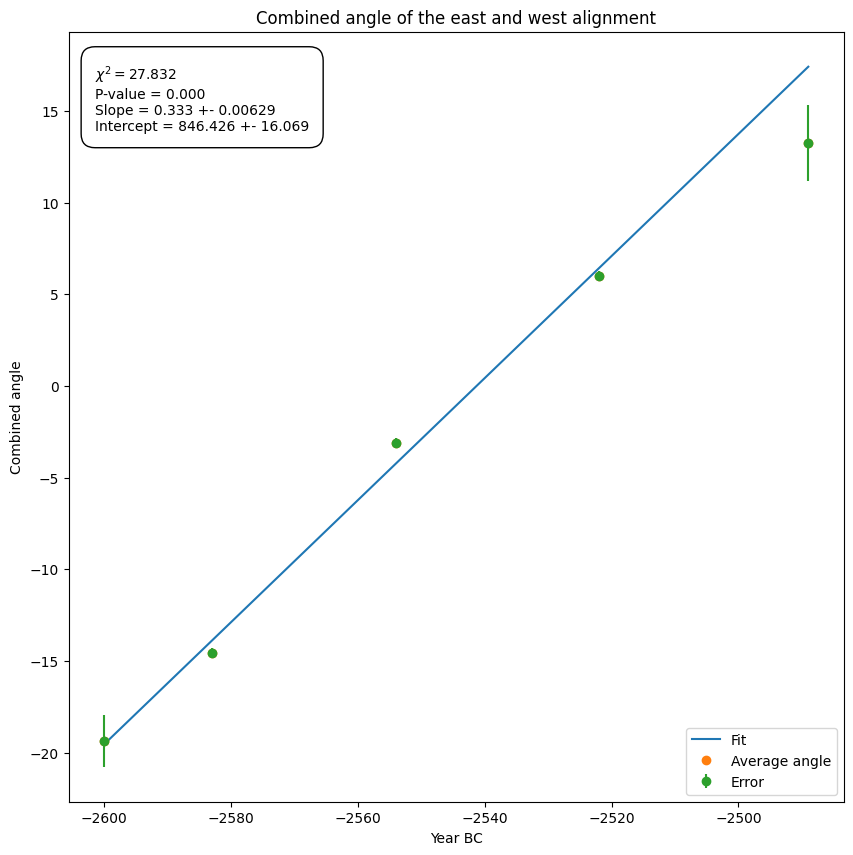

In [147]:
testyear = valid_year-valid_year[0]
chi2fit = LeastSquares(valid_year,new_angle,newerr,linfunc)
m20 = Minuit(chi2fit,a = 1,b = 1)
m20.migrad()
pval20 = stats.chi2.sf(m20.fval, len(valid_year)-2)
plt.plot(valid_year,linfunc(valid_year,*m20.values), label='Fit')
plt.title(f'Combined angle of the east and west alignment')
plt.plot(valid_year,new_angle, 'o', label='Average angle')
plt.xlabel('Year BC')
plt.ylabel('Combined angle')
plt.errorbar(valid_year,new_angle, yerr = newerr, fmt = 'o', label='Error')
strtext = '\n'.join((
    f'$\chi^2 = {m20.fval:.3f}$',
    f'P-value = {pval20:.3f}',
    f'Slope = {m20.values["a"]:.3f} +- {m20.errors["a"]:.3}',
    f'Intercept = {m20.values["b"]:.3f} +- {m20.errors["b"]:.3f}'
))
plt.text(5.25, 700, strtext, transform=ax[1].transData,
           fontsize=10, verticalalignment='top',
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.legend(loc = 'lower right')
plt.show()



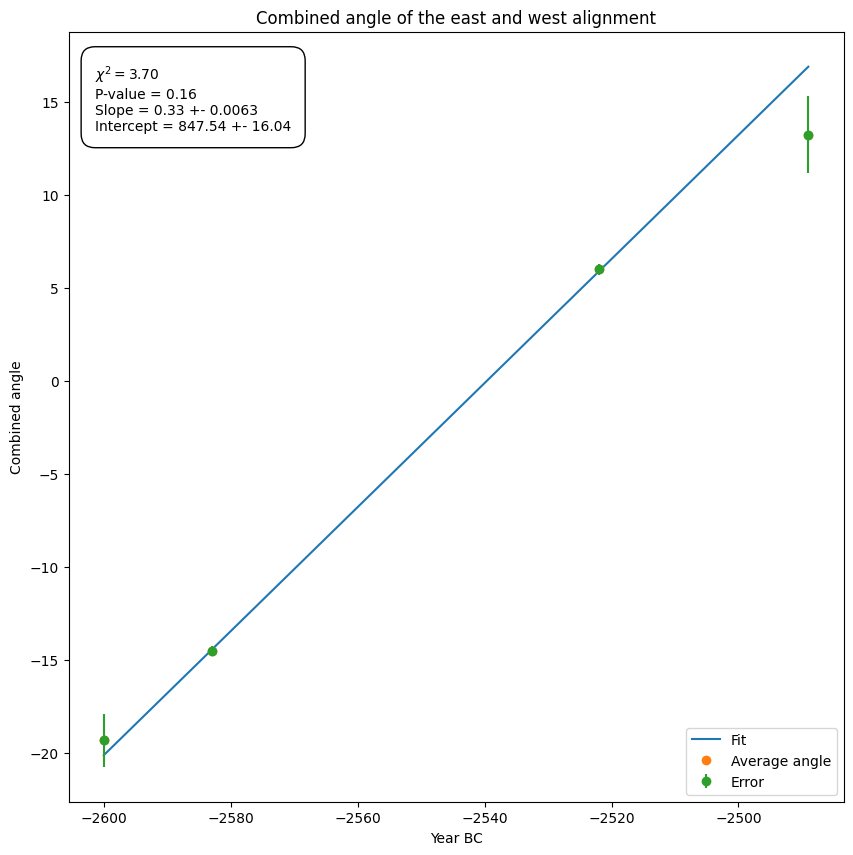

In [148]:
middle_index = 2

valid_year_mask = np.ones(len(valid_year), dtype=bool)
valid_year_mask[middle_index] = False
valid_year2 = valid_year[valid_year_mask]
new_angle2 = new_angle[valid_year_mask]
chi2fit = LeastSquares(valid_year2,new_angle2,newerr[valid_year_mask],linfunc)
m21 = Minuit(chi2fit,a = 1,b = 1)
m21.migrad()
pval21 = stats.chi2.sf(m21.fval, len(valid_year2)-2)
plt.plot(valid_year2,linfunc(valid_year2,*m21.values), label='Fit')
plt.title(f'Combined angle of the east and west alignment')
plt.plot(valid_year2,new_angle2, 'o', label='Average angle')
plt.xlabel('Year BC')
plt.ylabel('Combined angle')
plt.errorbar(valid_year2,new_angle2, yerr = newerr[valid_year_mask], fmt = 'o', label='Error')
strtext = '\n'.join((
    f'$\chi^2 = {m21.fval:.2f}$',
    f'P-value = {pval21:.2f}',
    f'Slope = {m21.values["a"]:.2f} +- {m21.errors["a"]:.2}',
    f'Intercept = {m21.values["b"]:.2f} +- {m21.errors["b"]:.2f}'
))
plt.text(5.25, 700, strtext, transform=ax[1].transData,
           fontsize=10, verticalalignment='top',
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.legend(loc = 'lower right')
plt.show()
